In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [13]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    inpMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
    rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
    rOutput_trials = np.zeros((n_trials, TRIAL_TIME, N_OUTPUT_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC
            inpMD = np.array(data["network_rates"]["MD_input"])
            inpMD_trials[idx,:,:] = inpMD
            rMD = np.array(data["network_rates"]["r_MD"])
            rMD_trials[idx,:,:] = rMD
            rOutput = np.array(data["network_rates"]["r_output"])
            rOutput_trials[idx,:,:] = rOutput

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output, inpMD_trials, rMD_trials, rOutput_trials)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = 50 #math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = 150 #CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [11]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [18]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]

for i in range(len(RUNS_MD)):
    print("Running " + str(i) + "/" + str(len(RUNS_MD)) + "...")
    data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
    data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
    save_obj(RUNS_MD[i], data_MDon)
    save_obj(RUNS_MD_NO[i], data_MDoff)

Running 0/10...
Running 1/10...
Running 2/10...
Running 3/10...
Running 4/10...
Running 5/10...
Running 6/10...
Running 7/10...
Running 8/10...
Running 9/10...


In [19]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]


scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 5
    
    (rPFC_trials, task_input, v1v2_values, wPFC_output, _, _, _) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)
        
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD, _, _, _) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)

Optimization terminated successfully.
         Current function value: 0.021781
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.310340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140587
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.604854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.517371
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.063892
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671538
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.520238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.606765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169819
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.266086
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.276446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012547
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.653216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691521


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.072492
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.309169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.052352
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684401
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176224
         Iterations 9
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208063
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.269640
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.025375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020714
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.028438
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.021110
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020730
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.469

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.293496
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293310
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076792
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.531463
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075516
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017752
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022969
         Iterations 12
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667449
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058850
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.280552
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097872
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508583
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.484808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077640
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.140315
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671523
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.446042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668367
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.339751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.210146
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026468
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155616
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.108705
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084874
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.043227
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291797
         Iterations 7
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624392
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.189777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263110
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023411
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.338437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.100030
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025136
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.641148
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.014240
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152201
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.401026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.516881
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.142356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.068242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072109
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692111
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015934
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.604039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.174447
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016399
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.391371
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.622147
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010078
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.074389
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033039
         Iterations 10
         Current function value: inf
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.222570
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.522579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.520479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083430
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013727
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.152688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425306

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.116621
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060810
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.492672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.233886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019227
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.199125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.033187
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677252

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.106326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.613182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172811
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.551753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049818
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.598938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.155333
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214400
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.669240
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.398468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.064924
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.248942
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.062283
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.100520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146750


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049122
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033455
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.318294
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675226
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052011
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.212749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029386
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.026594
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019257
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.104532
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.11349

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.126721
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105888
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051237
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.139335
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.547741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689590
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.341426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.114696
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.047452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.562310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.122170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.271729
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023284
         Iterations 14
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689583
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.354195
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111348
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.626981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076504
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.266346
         Iterations 8
         Current function value: 0.687721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029608
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.585278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021215
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.553569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027835
         Iterations 11
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.062918
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.132763
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105612
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689741

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023619
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.280386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035635
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.086494
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.275024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133962
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029265
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197558
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.153345
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.034303
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154834
         Iterations 9
         Current function value: 0.689894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.073931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.278721
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.019888
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232112
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004838
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.018307
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026334
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.105438
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692834
         Iterations 4
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.431374
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016931
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.043168
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.141273
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033639
         Iterations 10
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.454250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092657
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.267480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.309616
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039023
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.365958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046720
         Iterations 12
         Current function value: 0.019888
         Iterations: 50
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.101527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.473390
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.279683
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.154635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187004
         Iterations 9
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068345
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602372
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.562995
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.307614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105464
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687614
         Iterations 5
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019888
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.338627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427799
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136057
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.073869
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.577863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692145


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217497
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013099
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.171445
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.224479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.644007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691890
         Iterations 4
         Current function value: 0.000012
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050024
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 5
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.339820
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.660016
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.022145
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.679536
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597637
         Iterations 6
         Current function value: 0.689582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125885
         Iterations 10
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044752
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091984
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.313504
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043416
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035801
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007973
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.605559
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.464094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.542799
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.568690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.149576
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.096484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.578822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.082639
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.045388
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.614831
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102557
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092594
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.056620
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691273
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543204
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671036
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019713
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024695
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.470392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.587931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.209917
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058940
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.416500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529204
         Iterations 6
         Current function value: 0.619533
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442697
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101729
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222700
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.623088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535620
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.045111
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000366
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300952
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.442203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684794
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352033
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651663
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083998
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.147683
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.332364
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020053
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012511
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.071809
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.310409
         Iterations 8
         Current function value: 0.000000
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.700615
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.622621
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.279302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.612775
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121840
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294720
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075017
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132708
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.145338
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.343129
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113205
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.636480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010111
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043684
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146668
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688321
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034030
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007905
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.043134
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.070563
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.474649
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060787
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.122955
         Iterations 9
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466761
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043849
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.749584
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119497
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015684
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.192548
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.161849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.351334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006906
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.037005
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.004736
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.342127
         Iterations 8
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.186285
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049250
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047788
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.163907
         Iterations 9
         Current function value: 0.000042
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020257
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203523
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.459378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239865
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.123332
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684610
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326240
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030885
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.306602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016110
         Iterations 13
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021912
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.400000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187969
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.498761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685405
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085875
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.254043
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.166817
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013330
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102441
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.340032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.482778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.348691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178905
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.142813
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.437997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053955
         Iterations 10
         Current function value: 0.942286
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063568
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494705
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676421
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358277
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428358
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.033632
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069440
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.442668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.068210
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.158758
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.037185
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.127284
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006401
         Iterations 26
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390455
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051144
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034054
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016845
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.039998
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050863
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054761
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015786
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.050876
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.109297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.641143
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278587
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.271485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.216572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126127
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027232
         Iterations 12
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104709
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665490
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691958
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062546
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.079498
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.311547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.225309
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024752
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040318
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010078
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287884
         Iterations 8
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.244100
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634673
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053493
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.264727
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.153288
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129733
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677653
         Iterations 28
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589012
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012214
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.272674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676759
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668999
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.519127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024154
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.281875
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230750
         Iterations 9
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651200
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691940
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692169
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.048627
         Iterations 11
         Current function value: 0.445526
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015896
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.600990
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.450480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.171353
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097852
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.231972
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123468
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073446
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255365
         Iterations 8
         Current function value: 0.511504
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.081710
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010518
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.043084
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.077857
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010589
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115837
         Iterations 9
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013032
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.293150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008627
         Iterations 14
         Current function value: 0.003386
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.488443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009006
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.295902
         Iterations 11
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.450415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139478
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.454636
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.482298
         Iterations 7
         Current function value: 0.000101
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013792
         Iterations 13
         Current function value: 0.127282
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622490
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689816
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576173
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.230085
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018165
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.189764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024722
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379464
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.165971
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035175
         Iterations 14
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692683
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069812
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048767
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110178
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.105058
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632328
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.674663
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021912
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272809
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.167010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.188489
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.639048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493581
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010003
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000030
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.049496
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020351
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.601106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029504
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076612
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.115145
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031154
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.292079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670974
         Iterations 6
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213897
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013326
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188484
         Iterations 9
         Current function value: 0.035669
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.526789
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070489
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378412
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039706
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.677082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.154050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.261241
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.572572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027236
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.465921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.028533
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032022
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422843
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138315
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.342115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011943
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179593
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023045
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049432
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013453
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.646815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024001
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.6774

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689655
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639693
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.006378
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.070551
         Iterations 11
         Current function value: 0.671147
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.184919
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.156666
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019946
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682993
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065170
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.580459
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038645
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.218473
         Iterations 8
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.284361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.294322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623925
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.678005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252858
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018143
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.687430
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023537
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682837
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165148
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257497
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679961
         Iterations 24
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.680640
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109870
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659975
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.645006
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.100272
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029410
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149693
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067380
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094025
         Iterations 10
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630359
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085331
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087699
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024552
         Iterations 11
         Current function value: 0.000078
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692788
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019242
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.656910
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683646
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.656651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296746
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.185228
         Iterations 9
         Current function value: 0.688325
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021932
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.149344
         Iterations 8
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.304728
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690478
         Iterations 4
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016690
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.619316
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686730
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085354
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242624
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026660
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.519271
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051040
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.619647
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.402858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.173249
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.578131
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102528
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.571082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.240728
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.664324
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691679
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344876
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679396
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690204
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.252955
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.176943
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019988
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600109
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152766
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011090
         Iterations 13
         Current function value: 0.162612
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093151
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014235
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018282
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.375713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.169177
         Iterations 9
         Current function value: 0.000153
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.139779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.135959
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.078302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111204
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.054506
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.036489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.478728
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.544758
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033555
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.180508
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060634
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.602512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.450159
         Iterations 7
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101255
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.621750
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040628
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.125417
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.353014
         Iterations 8
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045059
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.387483
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024649
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.231336
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.275167
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692946
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.013601
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.050303
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020775
         Iterations 13
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037687
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.045843
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032479
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692520
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.682969
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364114
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.051038
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.182679
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013441
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049632
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.125608
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026131
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009482
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.064309
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.327912
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.051388
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.117428
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.036056
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.106683
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593414

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659311
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691508
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209431
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067214
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449751
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200026
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020387
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.684704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.107816
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.551581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.166429
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124674
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026018
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047401
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094611
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041897
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.030464
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013717
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.434976
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039540
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.066054
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.166679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.288630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.621987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074811
         Iterations 9
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617206
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.320839
         Iterations 7
         Current function value: 0.656249
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034405
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.616961
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.301945
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021915
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054615
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017903
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031481
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692209
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.530673
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227141
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.019979
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031408
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019518
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.072406
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627642
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036772
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.168931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.251882
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.268528
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692619
         Iterations 5
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040598
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.026548
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022442
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689250
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219676
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005674
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.133042
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309150
         Iterations 8
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.253274
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017707
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.154861
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.459833
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.534696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341657
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.269153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085071
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013040
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.673514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397028
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007991
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.278760
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680517
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.214008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.088450
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062924
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.476920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014799
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.015300
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.105352
         Iterations 8
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684266
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015581
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.547426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358784
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297161
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.135302
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117413
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.090278
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183395
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038698
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.108438
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638300
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160483
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692731
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179405
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022029
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.119976
         Iterations 8
         Current function value: 0.019888
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.488832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.180670
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.530082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067200
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022192
         Iterations 12
         Current function value: 0.689895
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549687
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017946
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023871
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.047474
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083020
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026661
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.222742
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010410
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053194
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023734
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.077964
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226570
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.397990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241078
         Iterations 8
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.614677
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027644
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.671934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314635
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027943
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.044506
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.106877
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.53075

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073008
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124423
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.529843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046949
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015893
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.666933
         Iterations 5
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.173615
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022938
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022820
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.057632
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.180630
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170231
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.573631
         Iterations 6
         Current function value: 0.395642
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.531071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.062094
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.203047
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026362
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072062
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229410
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018907
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.460723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661924
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024842
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689444
         Iterations 7
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020460
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.296163
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138711
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.233813
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101236
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691893
         Iterations 6
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014054
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.558160
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095233
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014814
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029388
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.058168
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055311
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690991
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043700
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.020112
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026080
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025491
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.434254
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.402084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692946
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.433639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103889
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145976
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.167484
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.391765
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021076
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.106658
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.114798
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.019044
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.023078
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133169
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.435840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065319
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132625
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011222
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.050709
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007918
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.124982
         Iterations 8
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049950
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050234
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.387339
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116425
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024306
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035184
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690699
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061287
         Iterations 9
         Current function value: 0.649485
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010745
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.204040
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020112
         Iterations 20
         Current function value: 0.000045
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116989
         Iterations 9
         Current function value: 0.378776
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130286
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079112
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.264554
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.061741
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027298
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.060773
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146656
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.218431
         Iterations 9
         Current function value: 0.663229
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035552
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198221
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.597980
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120338
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027954
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.664559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.043728
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.233119
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324948
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021748
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.041263
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.201764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.300746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.547648
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.279052
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020158
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.689582
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.045792
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.569166
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030391
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689756
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274239
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042332
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666698
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563734
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040564
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047783
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651087
         Iterations 6
         Current function value: 0.371521
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175163
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022106
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020141
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030088
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000016
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129509
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.079125
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692374
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045070
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.423094
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.448062
         Iterations 7
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051851
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.513779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.077203
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.109603
         Iterations 9
         Current function value: 0.000042
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032405
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058248
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034200
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.370945
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 25
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028468
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.398977
         Iterations 7
         Current function value: 0.678921
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.107659
         Iterations: 50
         Current function value: 0.692371
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038861
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.639960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.022145
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009060
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.136377
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286288
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051396
         Iterations 16
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.107788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.196969
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193109
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024126
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.642194
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013993
         Iterations 12
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598109
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000480
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643774
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687298
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072034
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189503
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.202964
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031207
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692047
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439611
         Iterations 7
         Current function value: 1.619857
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065796
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637031
         Iterations 6
         Current function value: 0.604120
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018833
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024330
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.571514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.233615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102072
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017065
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118966
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.128613
         Iterations 9
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040644
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.438891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044540
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.294740
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324885
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.665385
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.352632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390971
         Iterations 10
         Current function value: 0.000000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.044428
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.034842
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.355211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.097079
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060448
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.507849
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659716
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065440
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412917
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670092
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.323640
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657552
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063373
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.463765
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057483
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065649
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.384439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.469789
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.397517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058516
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384736
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.638216
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652752
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.638244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518114
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039717
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.655047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639251
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017758
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043807
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.592880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.215192
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598804
         Iterations 5
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660270
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.645642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.290366
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.023001
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.579636
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219867
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016022
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.611405
         Iterations 6
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.088908
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471486
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170497
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009333
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.007019
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.683932
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.032140
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.038762
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640794
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.321862
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.015008
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287155
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080691
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148272
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021549
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689936
         Iterations 5
         Current function value: 0.014672
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110123
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217166
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020768
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.440633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.553071
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009898
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.146594
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138817
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.136108
         Iterations 11
         Current function value: 0.000071
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273619
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299927
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010901
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.038603
         Iterations 11
Optimization terminated successfully.
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429938
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055008
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013726
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.241563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036487
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.357806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021898
         Iterations 13
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025850
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.130043
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.345519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594291
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.252463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.634532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.096830
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679365
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.063581
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.661251
         Iterations 5
         Current function value: 0.683815
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422090
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046390
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049667
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018463
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.133640
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.484601
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025272
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689612
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016482
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.175108
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121872
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684164
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.651905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030762
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034284
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666301
         Iterations 5
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.234489
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008276
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083336
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007512
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.042601
         Iterations 11
         Current function value: 0.688378
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007341
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.027386
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049095
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315749
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036318
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083218
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.646444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446774
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355328
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.351301
         Iterations 7
         Current function value: 0.560976
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406747
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.321601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.060897
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461146
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.177876
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039234
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.423633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054679
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.404595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011653
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050087
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.470079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010582
         Iterations 13
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058107
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685024
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.243489
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197756
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.440210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026785
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035315
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145926
         Iterations 9
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.681819
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328942
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041293
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.540668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031387
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009315
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.301189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.609268
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.191746
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.581060
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021870
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.056607
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692733
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255525
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025032
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.528237
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283132
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.468335
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.218230
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082836
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.354724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689669
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082188
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561003
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244588
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.306497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362098
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064700
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076884
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.001855
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026070
         Iterations 11
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.081025
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599850
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355999
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361618
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239769
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639704
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339055
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.120280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048741
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.246388
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303876
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364309
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.562867
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066203
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.389598
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042148
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.308364
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035220
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017627
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110836
         Iterations 10
         Current function value: 0.000009
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107954
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.661345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.136719
         Iterations 10
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025255
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017993
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.604085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454271
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.344826
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.324702
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.273820
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689441
         Iterations 4
         Current function value: 0.690385
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007642
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019915
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.231288
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029874
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.023168
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.176749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162697
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.085762
         Iterations 10
         Current function value: 0.681554
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028993
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.190272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164053
         Iterations 9
         Current function value: inf
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073591
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087105
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038430
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088152
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.582268
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574505
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676171
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145128
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.029209
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.407515
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008253
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020134
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.078910
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265241
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333369
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024945
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.357284
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092527
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.209217
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009026
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184813
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.459606
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011367
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.675403
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.027432
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224776
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.409287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689223
         Iterations 5
         Current function value: 0.020135
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155680
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248610
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166155
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692790
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.048276
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.615976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.261860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.186412
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.382882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373696
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.556290
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.095904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.632755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008578
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052295
         Iterations 11
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046538
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.110169
         Iterations 10
         Current function value: 0.019429
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689650
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559682
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.581556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.100579
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.490443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468343
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.463512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.047339
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243028
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010511
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.663091
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.255020
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011257
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.414646
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053800
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445871
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.431734
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554331
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008355
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.077635
         Iterations 11
         Current function value: 0.000404
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.301246
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.396899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447869
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069705
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389944
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.455612
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373607
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.134187
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.190316
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306587
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663711
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144943
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669040
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.008480
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.649157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472809
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.162329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.061597
         Iterations 11
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000013
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.601274
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594094
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.357725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448236
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.122251
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.686378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.053235
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.032386
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.539043
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014470
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639209
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.092092
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608198
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317046
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240188
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187732
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.0123

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.257437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.162931
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.235166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591532
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600641
         Iterations 7
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068673
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.663059
         Iterations 35
Optimization terminated successfully.
         Current function value: 0.127642
         Iterations 9
         Current function value: 0.363288
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.361907
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010836
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.050784
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.124138
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.402096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519527
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.182952
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196646
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010944
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.011459
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132646
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.013114
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.267973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171673
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.122446
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667152
         Iterations 5
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010190
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.645567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106725
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390600
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096512
         Iterations 11
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442951
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160697
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092692
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149731
         Iterations 33


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013449
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.335396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.164726
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286228
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049571
         Iterations 11
         Current function value: 0.663059
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.213314
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076069
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034523
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.358380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.083151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664353
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146664
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160204
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017459
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104654
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300989
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086144
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301436
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.192406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157874
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689952
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571015
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.103848
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.566141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.208869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071275
         Iterations 9
         Current function value: 0.688451
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220677
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.105985
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052507
         Iterations 12
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632293
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063465
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113734
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.663408
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.071242
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.086689
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030529
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127811
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.046212
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.019208
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261195
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005638
         Iterations 18
         Current function value: 0.051439
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204518
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.014665
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012359
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.169284
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082889
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011040
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.041147
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.148649
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.5260

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.439782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.544321
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679743
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529692
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049314
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.080675
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051237
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049689
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042492
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014113
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.688178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.252646
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.507002
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019608
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016242
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.072930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101123
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688184
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096238
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.323943
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225789
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.417251
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.663059
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025501
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.659213
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017786
         Iterations 16
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013652
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027756
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.314903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.568170
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.297069
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125606
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.325234
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194097
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105855
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.338294
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239693
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.193227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427166
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.00

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670042
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.081971
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663059
         Iterations 21
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131223
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.403788
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009773
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.026446
         Iterations 12
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.306426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.302060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089686
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043933
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014557
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014101
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.068858
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.233051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.109836
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.475855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005831
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.056486
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.301290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182053
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.663059
         Iterations 40
Optimization terminated successfully.
         Current function value: 0.667593
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682349
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027149
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.219056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030633
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.031380
         Iterations 12
         Current function value: 0.302597
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148246
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034825
         Iterations 12
         Current function value: 0.557847
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019284
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461939
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046062
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.674743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033801
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.147159
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149457
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.404960
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034017
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.431356
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019934
         Iterations 25
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055499
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044107
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.149731
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.033358
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427629
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.081977
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.490469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269547
         Iterations 7
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.475981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.198996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.153398
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.168144
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.515476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073325
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.578265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079305
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.490556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045896
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252641
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.179897
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690069
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674640
         Iterations 43
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435953
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.180934
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691470
         Iterations 5
         Current function value: 0.019934
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683703
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.204467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.312304
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351701
         Iterations 34
Optimization terminated successfully.
         Current function value: 0.309701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676923
         Iterations 28
         Current function value: 0.000000
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669760
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50
         Current function value: 0.035668
         Iterations: 50
         Current function value: 0.510832
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.177818
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671252
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670837
         Iterations 7
         Current function value: inf
         Iterations: 50
Op

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.663059
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363842
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.546385
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640580
         Iterations 15
         Current function value: 0.628980
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136132
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.396931
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692485
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.502157
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021600
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.681453
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.246324
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.277338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.130500
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.237399
         Iterations 9
         Current function value: 0.692877
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005887
         Iterations 18
         Current function value: 0.192310
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010548
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.192432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.517785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.384851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151880
         Iterations 9
         Current function value: 0.654976
         Iterations: 50
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.348265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646112
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.291978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676218
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.640254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032284
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074314
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.214563
         Iterations 11
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648181
         Iterations 8
         Current function value: 0.663059
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312056
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016998
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.161734
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692792
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.087827
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144862
         Iterations 12
         Current function value: 0.850121
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613286
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208358
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.219286
         Iterations 21
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.663059
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.493512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.257874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.142772
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690169
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.292599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.108354
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.402727
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206448
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642419
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000008
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017402
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.280494
         Iterations 8
         Current function value: 17.683063
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066054
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.411083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.528760
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.378107
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.589761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.234533
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277970
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173863
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455094
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000153
         Iterations: 50
         Current function value: 0.000000
         Iterations: 5

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174520
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009184
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559479
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160611
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685629
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.502652
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.161499
         Iterations 9
         Current function value: 0.690385
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582312
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617812
         Iterations 31
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.117332
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234316
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680662
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161130
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.113615
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562634
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054528
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.272926
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382205
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034159
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010537
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.511665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.008529
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.592678
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.136063
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159406
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029294
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.095282
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058978
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673988
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350296
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667261
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 2.612822
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016742
         Iterations 13
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.507874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129122
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107989
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.539815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.180812
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692585
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022528
         Iterations 12
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539930
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017423
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.236534
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.478087
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.065428
         Iterations 11
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180588
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010987
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.262017
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151230
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064353
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000025
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010154
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415495
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532116
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035405
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.223782
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431127
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020156
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175550
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609165
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157239
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.003196
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.507667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441036
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032380
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015065
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.216746
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244732
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.609183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604835
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388109
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157969
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059876
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.044927
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127551
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.115009
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360865
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137818
         Iterations 9
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149965
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191066
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.296818
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284531
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031152
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.489416
         Iterations 19

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652023
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292907
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000011
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069894
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032141
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.186999
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384624
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.085614
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.218913
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632477
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038026
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.268227
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000307
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233110
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098937
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052251
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119600
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.050615
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.0000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.216176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157694
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598298
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328743
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131015
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029754
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.213965
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040953
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031783
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673751
         Iterations 5
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026287
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.526031
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.109994
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050196
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009007
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.143693
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.536464
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028027
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559993
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007046
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.602517
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262944
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151436
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134144
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079797
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.011107
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.050982
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136873
         Iterations 10
Optimiza

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030080
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.318917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050707
         Iterations 12
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009389
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.680211
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.249143
         Iterations 8
         Current function value: 0.690168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063639
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670260
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565768
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628086
         Iterations 6
         Current function value: 0.641377
         Iterations: 50
         Current function value: 0.085424
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049124
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274840
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691465
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092740
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054108
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.681656
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692581
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.463797
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.314085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111784
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.549733
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.059441
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331680
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.650245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014144
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144526
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.548106
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265425
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.428430
         Iterations 7
         Current function value: 0.020156
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674887
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.324415
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246139
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568085
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.123009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058695
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.294502
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181595
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130968
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612150
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017422
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010547
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.161487
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213330
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.109702
         Iterations 9
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072947
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.381510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250482
         Iterations 8
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.167252
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670811
         Iterations 5
         Current function value: 0.257123
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624874
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034808
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.158941
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.434944
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420120
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051703
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690382
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520472
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.307536
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.614944
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297710
         Iterations 13
         Current function value: 0.672637
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012384
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165946
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409716
         Iterations 7
         Current function value: 0.035270
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086729
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.436907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560254
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588130
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021796
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512480
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.007638
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.596033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058553
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.215290
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.668236
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678218
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.569482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200773
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.479240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082532
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.033823
         Iterations 16
         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010664
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.018689
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.116290
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027010
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.332369
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028895
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.084859
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.023075
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.564438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.573061
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033292
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.028596
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158559
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.624256
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005644
         Iterations 20
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.415270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.225773
         Iterations 8
         Current function value: 0.016476
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115844
         Iterations 9
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.668806
         Iterations 8
         Current function value: 12.350592
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009358
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.472388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.196118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031376
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.319033
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.640828
         Iterations 7
         Current function value: 0.692697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.549078
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353274
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.308574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692592
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.593879
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043926
         Iterations 13
         Current function value: 0.000021
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033107
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.120825
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015125
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.008758
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.205180
         Iterations: 50
         Current function value: 0.670019
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579204
         Iterations 6
         Current function value: 0.478908
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224939
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031482
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.105914
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.347415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.207691
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116710
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675620
         Iterations 6
         Current function value: 0.000088
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520529
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082560
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.402329
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.222147
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137338
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.154729
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271030
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155835
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570779
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.227120
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400847
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687986
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072045
         Iterations 11
         Current function value: 0.691881
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204201
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407609
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603004
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064576
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025147
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.242003
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267904
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692679
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034534
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.385258
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.433239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051944
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042059
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.156467
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071017
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042370
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597915
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299580
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.543581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037694
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100391
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135547
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.066826
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.149844
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599453
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.113718
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.038138
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.366300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074214
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.515251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.090371
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618079
         Iterations 6
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150684
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.262849
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023712
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.097165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.122793
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685103
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.260299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.602372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686421
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.665913
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.148702
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187955
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.476936
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.067227
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078228
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335288
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669566
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669715
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.132591
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.313296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219202
         Iterations 9
         Current function value: 0.690389
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289055
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.066100
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.527162
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.035337
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.207187
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117262
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315155
         Iterations 7
         Current function value: 0.123817
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099598
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691483
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473813
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692426
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683322
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.125619
         Iterations 11
         Current function value: 0.589406
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.504587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185394
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029371
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.472220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670817
         Iterations 4
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682557
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129597
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.452715
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308682
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640813
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690858
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260077
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592192
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120996
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151636
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.501990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.551811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032299
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.314500
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008286
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.010621
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.574839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.047236
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.542625
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120949
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010280
         Iterations 37
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440787
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662612
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676766
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318100
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290088
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123849
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020443
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681357
         Iterations 5
         Current function value: 0.000035
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.691993
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011899
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.087902
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692677
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665428
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.540487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321719
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.060071
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.410138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016565
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.256142
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152164
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127312
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323550
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013099
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.562625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.056057
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.319733
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007051
         Iterations 14
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.318125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261332
         Iterations 9
         Current function value: 0.020443
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028209
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.321919
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030697
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.670019
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.080461
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017885
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.665787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.148111
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007971
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.628881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219810
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.365791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272656
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433795
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292421
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678794
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171812
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.683186
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032189
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.140179
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124035
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.142882
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.297299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485089
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093383
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031656
         Iterations 10
         Current function value: 0.432831
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.537192
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.192566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034355
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.686247
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675500
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155039
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692654
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.283165
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.061405
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.624143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453497
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.042950
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031341
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098643
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019938
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689577
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128333
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.133978
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409098
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188835
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.610122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008617
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.130592
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042547
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.046409
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441412
         Iterations 8
         Current function value: 0.000000
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024878
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.095140
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653993
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060749
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675920
         Iterations 4
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124751
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.123817
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636331
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.648276
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.261937
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060662
         Iterations 11
         Current function value: 0.616484
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685984
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016894
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.155227
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016785
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.011551
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.332915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.576686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232906
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.536649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.113630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.111668
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.326340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.159827
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039177
         Iterations 11
         Current function value: 0.123817
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.605346
         Iterations 6
         Current function value: 0.114498
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.283715
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105622
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.647914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005912
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.301171
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.123817
         Iterations 20
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675580
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672730
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090880
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367734
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.070388
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.073285
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087698
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.123817
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058491
         Iterations 11
Optimiz

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216969
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609316
         Iterations 6
         Current function value: 0.019974
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112314
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687758
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664183
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.299512
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498086
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015115
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319283
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.492096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.482185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.670019
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341651
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.038760
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.514406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055180
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.298300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.556863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692191
         Iterations 4
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131889
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017171
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.387660
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.228192
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.539326
         Iterations 8
         Current function value: 0.685454
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506783
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124792
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029982
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.045634
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.146396
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266865
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334232
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256942
         Iterations 8
         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684850
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071371
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.304333
         Iterations 8
         Current function value: 1.053979
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615666
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048681
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.672081
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255960
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344601
         Iterations 18
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070246
         Iterations 11
         Current function value: 0.963576
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678493
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.670019
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682600
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.285738
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608655
         Iterations 6
         Current function value: 0.670019
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054870
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115741
         Iterations 9
         Current function value: 0.670019
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.405644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007075
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.056396
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651383
         Iterations 6
         Current function value: 0.295445
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015213
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.382732
         Iterations 7
         Current function value: 0.651743
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623116
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032830
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.099187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043819
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.582003
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.477298
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017211
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024008
         Iterations 11
         Current function value: 0.123817
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000086
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146798
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.674064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.194943
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667296
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652369
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.123817
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613052
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.577422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013397
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.450851
         Iterations 8
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.650750
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667337
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.569807
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610824
         Iterations 6
         Current function value: 32.866473
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297673
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085881
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.175384
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.397527
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.510754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182817
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095965
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.640206
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.626032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093931
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.328431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.315913
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163191
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.220999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.430978
         Iterations 7
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.757673
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258539
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.561168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612075
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.316097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.367056
         Iterations 7
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581429
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115225
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052852
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298862
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089065
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229859
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049088
         Iterations 12
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020898
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689728
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682663
         Iterations 5
         Current function value: 0.504488
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201217
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.201962
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038821
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.489521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.086330
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439231
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212983
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046483
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.112016
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.150636
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057549
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.223824
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182426
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037912
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.358669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372636
         Iterations 7
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101585
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004732
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.649252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.281833
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195551
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.369564
         Iterations 6
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007464
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116614
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009956
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689063
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685389
         Iterations 4
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008638
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.042531
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686749
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.640035
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.126943
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.321733
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592490
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692576
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042475
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.062263
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406113
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667507
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691752
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.198760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.359550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267637
         Iterations 8
         Current function value: 0.690697
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041556
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115121
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.410627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690300
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531125
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688126
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.008338
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.646752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.186595
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.364225
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.622598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.276403
         Iterations 7
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671786
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111230
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590615
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351596
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685989
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690387
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286961
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669223
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148389
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.363585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.149320
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.618562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524840
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090758
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056511
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024423
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154901
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020026
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387057
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.008048
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.682969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651139
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692943
         Iterations 3
         Current function value: 0.000039
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688529
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370703
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011181
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.125772
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650791
         Iterations 37
Optimization terminated successfully.
         Current function value: 0.541343
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.446635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172570
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.201276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043143
         Iterations 14
         Current function value: 0.382442
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.568014
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.049088
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.516899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019057
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.364064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.099529
         Iterations 13
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.108758
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.337524
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016567
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.031228
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.518836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060224
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.371107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.129262
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.565666
         Iterations 36
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.206162
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.042610
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318886
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000595
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447111
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323219
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024108
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.254884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.499792
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.412710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.193936
         Iterations 9
         Current function value: 0.564507
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.052567
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100937
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068415
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.213729
         Iterations 8
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.168803
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.402421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.128074
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.407925
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679522
         Iterations 4
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.278569
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034117
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.482424
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.396036
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.297670
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030029
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.676368
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692127
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236472
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686326
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323394


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064151
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516919
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.101358
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034905
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060723
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022226
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.684216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.052846
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017894
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191905
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.159928
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.527914
         Iterations 6
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.600282
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127542
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028517
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.065138
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506654
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027412
         Iterations 12
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687728
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.099476
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163778
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148094
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.302487
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.602527
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.185350
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.176521
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352436
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012834
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.117990
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020108
         Iterations 22
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009265
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.129164
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026822
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012016
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.302939
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583786
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211990
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565405
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.145732
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.145795
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.371127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690857
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612482
         Iterations 5
         Current function value: 0.176287
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.259692
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136110
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688277
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252241
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.184214
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.691073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.197930
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.237865
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160378
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528392
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680901
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683099
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676470
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 3.981650
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091823
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382274
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041320
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.074416
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004854
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166139
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383184
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.162615
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238508
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603055
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220179
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670735
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016334
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.562364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650118
         Iterations 14
         Current function value: 0.000170
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345050
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.488366
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.262058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055775
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429320
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.233822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599063
         Iterations 6
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.551754
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265917
         Iterations 9
         Current function value: 0.690697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053194
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.625666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.047606
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.419238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584114
         Iterations 6
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.475708
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019361
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.560780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656829
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329373
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680254
         Iterations 4
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009096
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692708
         Iterations 4
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.196239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688263
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675745
         Iterations 5
         Current function value: 0.020092
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685168
         Iterations 12
         Current function value: 0.556108
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473061
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.310518
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248747
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.563633
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.652544
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187790
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.034886
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.157107
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257149
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.518407
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050398
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.653806
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258815
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.292497
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677740
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682637
         Iterations 5
         Current function value: 0.693828
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023785
         Iterations 13

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.009888
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024694
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.474213
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.434012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692976
         Iterations 3
         Current function value: 0.925355
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.072154
         Iterations 11
         Current function value: 0.689172
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671842
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.650750
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.035627
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650750
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.047525
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105488
         Iterations 9
         Current function value: 0.650750
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.526636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125824
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.662696
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279798
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016380
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.495574
         Iterations 6
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.265324
         Iterations 11
         Current function value: 0.035419
         Iterations: 50
         Current function value: 0.654533
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000066
         Iterations: 50
         Current function value: 0.686211
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666108
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000031
         Iterations: 50
         Current function value: 0.184214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638815
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.581660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019462
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010138
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.486387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040285
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.487817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.261371
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043196
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.124918
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035450
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.657501
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692194
         Iterations 4
         Current function value: 0.124473
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093098
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666925
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.147672
         Iterations 9
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124464
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.192572
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.216964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.109206
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.027332
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406940
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066122
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294671
         Iterations 7
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210037
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.168839
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.277503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016238
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.118084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050596
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.128134
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037157
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.200617
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016557
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.078600
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.565285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074464
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006349
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.340516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027011
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081008
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.515311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327137
         Iterations 7
         Current function value: 0.657501
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503430
         Iterations 7
         Current function value: 0.124473
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465010
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034838
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.113334
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.308628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690124
         Iterations 4
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.124473
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.399527
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.145481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.184782
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009926
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022444
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021206
         Iterations 11
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.056920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022467
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.048489
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.054196
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125222
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.586094
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058373
         Iterations 10
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.340195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127261
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.038673
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.523011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.506856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.131312
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.470065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.287474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340553


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.435154
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518339
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084928
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.287517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.587718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352443
         Iterations 7
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.103388
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.052664
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.066338
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019580
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.580602
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091121
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.351169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225810
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.243870
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060105
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.145239
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.276289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010095
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039112
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682681
         Iterations 6
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118590
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692950
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688676
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.097867
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.073765
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.342565
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599088
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.144735
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028690
         Iterations 10
         Current function value: 0.657501
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685949
         Iterations 6
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075043
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.118929
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.164250
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692940
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005549
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.678463
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.66033

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079754
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.273751
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665393
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685452
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234229
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687003
         Iterations 5
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.553789
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025466
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.647915
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678080
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076758
         Iterations 9
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.388653
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020663
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145548
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009946
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.178805
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.451293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.366965
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.121564
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023178
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091520
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011139
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.047768
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671817
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.414579
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059228
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.169745

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019196
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014888
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.048517
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.127552
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063554
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.187037
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.335007
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336530
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.53000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071583
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.124484
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.599501
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193041
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.639593
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143377
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149463
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069073
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.159953
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087710
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219870
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026685
         Iterations 11
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.407463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693108
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.114636
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.498300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.159447
         Iterations 8
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000815
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414767
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.541878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012656
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.113924
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.553392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172472
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040259
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.493346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.040336
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693104
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032657
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100823
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.124572
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.272690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354088
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036247
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034634
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.384939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.147165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.380072
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334140
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220541
         Iterations 8
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028688
         Iterations 11
         Current function value: 0.354070
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020220
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.682031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.127438
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190924
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065379
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433534
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.021048
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674229
         Iterations 10
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.097585
         Iterations 10
         Current function value: 0.000267
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099306
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127360
         Iterations 8
         Current function value: 0.655029
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050069
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.445532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347632
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 134.932648
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067895
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.478360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303635
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108569
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027012
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102235
         Iterations 13
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.054511
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.228891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602659
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.318120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.099531
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.669433
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.645277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.126069
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075796
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.115285
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667002
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053714
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133266
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.147031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278926
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.226378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.669541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.171544
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.669277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676821
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.523324
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.606238
         Iterations 6
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010140
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.453782
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.150436
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061224
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029062
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114462
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.277815
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163556
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042324
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.661140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677102
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.069209
         Iterations 10
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.657501
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367440
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074917
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.200032
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127543
         Iterations 9
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018450
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.178119
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.047756
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088031
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101043
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684778
         Iterations 5
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.576991
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690871
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.022915
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047358
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.088014
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.278823
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.552860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.102500
         Iterations 9
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.453287
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683174
         Iterations 5
         Current function value: 0.657501
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137134
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.155718
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691636
         Iterations 7
         Current function value: 0.232563
         Iterations: 50
         Current function value: 0.061834
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.086273
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057695
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.233116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.090301
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.089364
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030709
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.532956
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.524775
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.234654
         Iterations 8
         Current function value: 0.681454
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232767
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.100371
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.394232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.672483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074697
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.376975
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043536
         Iterations 10
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.135611
         Iterations 11
         Current function value: 0.124478
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683311
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022120
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.625899
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.244020
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.059467
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.592437
         Iterations 7
         Current function value: 0.124473
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016124
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.227637
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058530
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692685
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624304
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062151
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683026
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024338
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688160
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596521
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.443842
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255355
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031481
         Iterations 13
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024764
         Iterations 13
         Current function value: 0.216600
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231176
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365858
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010829
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.498019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.282442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.571185
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.563174
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.074729
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.601213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116996
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.209258
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030714
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.551997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.236603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668998
         Iterations 5
         Current function value: 0.669953
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544093
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027735
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.578560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.205761
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688504
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008068
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098881
         Iterations 10
         Current function value: 0.689225
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029628
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111815
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012987
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037671
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.072172
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201401
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035264
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.340942
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352901
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119666
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.392971
         Iterations 7
         Current function value: 0.000403
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151759
         Iterations 9
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014553
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691708
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684254
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140119
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.641924
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020051
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.612056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621508
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691724
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000047
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.419912
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294801
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008599
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033624
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.312087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012716
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.224576
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390511
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.120749
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016365
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.064807
         Iterations 11
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.510719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040604
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692922
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031707
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.156349
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019381
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.038089
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.015009
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.690787
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.634764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.179514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.444

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030017
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.283612
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582269
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690442
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173833
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010108
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.105574
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097091
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690972
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.316609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015365
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.018374
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.320997
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274560
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066644
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131614
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378896
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104336
         Iterations 10
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.489036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.270434
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691962
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.540071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443878
         Iterations 7
         Current function value: 29.007422
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156126
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015415
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.083086
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024988
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.442019
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020219
         Iterations 42
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679566
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143968
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.608664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007181
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.131613
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.288830
         Iterations 8
         Current function value: 0.690787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064295
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670388
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082597
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681388
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688504
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049651
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080405
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024991
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638535
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039133
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.063851
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.521115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691507
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.428796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006073
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.010205
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.016701
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026547
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.561499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083885
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.083795
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042452
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.640728
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.534826
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.510352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021603
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.622361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693045
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.039633
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021113
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.388566
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.298263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162745
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.223435
         Iterations 9
         Current function value: 0.000003
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.259111
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048666
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.057419
         Iterations 11
         Current function value: 0.553995
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673683
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043085
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169597
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588572
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.278999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036957
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.386263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.043929
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.493911
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.296628
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008654
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044199
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010112
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.525277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014215
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024036
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.265117
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072275
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006395
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015700
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005579
         Iterations 31
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.144764
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274171
         Iterations 11
         Current function value: 0.371090
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143120
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.272595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.474055
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006785
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.664082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.040060
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.027903
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029967
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690450
         Iterations 4
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.317641
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204909
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.556153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.561950
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089004
         Iterations 9
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022204
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116863
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082250
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023403
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.380267
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.087058
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.120847
         Iterations 10
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074242
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.223258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.125960
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022221
         Iterations 14
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.332883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.304587
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021871
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.516376
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279662
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032469
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.594844
         Iterations 6
         Current function value: 0.681641
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008262
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306045
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691350
         Iterations 4
         Current function value: 0.339218
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018631
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151913
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093930
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 25
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274487
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043943
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.480778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063417
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187307
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679003
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131775
         Iterations 9
         Current function value: 0.000166
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.189502
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.463081
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.097708
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.247660
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.510768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.159449
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418814
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130151
         Iterations 10
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678379
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074981
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036846
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024658
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.006699
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.460854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081610
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014090
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549595
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523855
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101262
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.247188
         Iterations 8
         Current function value: 0.689582
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213467
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628262
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559930
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.318919
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.535171
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.647745
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054665
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035489
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.036078
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145107
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675520
         Iterations 5
         Current function value: 0.423026
         Iterations: 50
         Current function value: 0.000000
         Iterations: 5

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042359
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082950
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688866
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.289065
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.330165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023806
         Iterations 11

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097974
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239367
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.280421
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029889
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051538
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.515853
         Iterations 6
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.125276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.618233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027901
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.188535
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.028784
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.142961
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678937
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044049
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.013113
         Iterations 14
         Current function value: 0.004738
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252672
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591754
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462192
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.404784
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079207
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035445
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.638894
         Iterations 5
         Current function value: 0.096491
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Iterations: 50
         Current function value: 0.688504
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541643
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.650877
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657720
         Iterations 5
         Current function value: 0.394758
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.189517
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.007744
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.040948
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.656849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.289270
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653642
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080022
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 28
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043771
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026758
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.587833
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013044
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.620043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.281881
         Iterations 33
Optimization terminated successfully.
         Current function value: 0.177241
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.098054
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652924
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375882
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.309197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.333800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410114
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596503
         Iterations 6
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241762
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.150778
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.520382
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.421667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027846
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106312
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.515341
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029774
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020865
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.537499
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031255
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.477784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310188
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.556509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.154816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.666353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.057990
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021523
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.033631
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.07974

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046551
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.151418
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059071
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.033124

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.232244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018624
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.414174
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065441
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.114198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.518957
         Iterations 6
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.568168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019201
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.652751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.168105
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.075244
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012529
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107937
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.408595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413815
         Iterations 7
         Current function value: 0.687349
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.399160
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.507447
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.662906
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107385
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095732
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.605436
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024707
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.507034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658844
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014739
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.271092
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.568448
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.600205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375192
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080569
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075020
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.406406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023693
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.267190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.545015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.247555
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652843

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681969
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.470857
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310360
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683761
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133867
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.005873
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055822
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034973
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.527947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052449
         Iterations 10
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.636916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007533
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019917
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.645307
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456163
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675505
         Iterations 5
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224606
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.066311
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046238
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.213971
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.056790
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687864
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.592139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024908
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.368541
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043193
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046397
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.384745
         Iterations 8
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.327594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055893
         Iterations 9
         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.262526
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029184
         Iterations 10
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103991
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025318
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.574211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.192830
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.564906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016097
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007906
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.096168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.010636
         Iterations 17
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.283088
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017933
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083511
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021886
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.051324
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066488
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106374
         Iterations 9
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.038546
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014151
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.062680
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038521
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.436930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.429229
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633309
         Iterations 6
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.312060
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039622
         Iterations 10
         Current function value: 0.690575
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.458838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217625
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025782
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021208
         Iterations 12
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084414
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046622
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.394875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.154145
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.168452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110744
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.033022
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035178
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.185997
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.184864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084038
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689197
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.436146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043126
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.393116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.028436
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.033344
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007327
         Iterations 14
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682277
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112420
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.645024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.130421
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.180560
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019810
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.568552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025264
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.190908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149920
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647396
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683683
         Iterations 5
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150322
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034122
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.061139
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.135369
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287648
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024121
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.623739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.021603
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.072660
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.063682
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.274729
         Iterations 8
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042638
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637579
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030219
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.271768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019810
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.085307
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046642
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013226
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.223095
         Iterations 8
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107919
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666168
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033661
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.412395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069673
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051319
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.022151
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055948
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052635
         Iterations 11
         Current function value: 0.687349
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515728
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006280
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.014918
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.128036
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019613
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.021038
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.173583
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052492
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031441
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.337006
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.386337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007180
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.677056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034742
         Iterations 12
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.414882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071482
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037987
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.290560
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008473
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072022
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.329995
         Iterations 7
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135239
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.687349
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109532
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.590814
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.012858
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.677065
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266496
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049428
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.198795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021550
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017300
         Iterations 13
         Current function value: 0.409216
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010954
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.060777
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043667
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.077242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.546516
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042135
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395650
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020589
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.590322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.063539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019320
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.112047
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068063
         Iterations 9
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.531332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.492390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031844
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.298693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091670
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028403
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.548876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.206521
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106365


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.206544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122467
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.203967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012320
         Iterations 14
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143029
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.442178
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021955
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.679928
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.632276
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023461
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.062567
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.552976
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022458
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.087373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.260216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032178
         Iterations 11
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.207384
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.103901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.045674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.257537
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.032464
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037621
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187858
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050196
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.015435
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.079129
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030891
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097402
         Iterations 13
         Current function value: 0.679284
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687858
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260374
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634437
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692895
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.017480
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.670616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046979
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031332
         Iterations 10
         Current function value: 0.674241
         Iterations: 50
         Current function value: 0.662579
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.259125
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089969
         Iterations 9
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.107077
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033636
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029238
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.687829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432925
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.671720
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.119453
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079751
         Iterations 10
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.692947
         Iterations 3
         Current function value: 0.103178
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246271
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030296
         Iterations 12
         Current function value: 0.019745
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182552
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.044803
         Iterations 10
         Current function value: 0.084376
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335486
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109215
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.408954
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005197
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.107427
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681899
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.545505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151550
         Iterations 10
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117624
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.275067
         Iterations 8
         Current function value: 0.000229
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.117709
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192748
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151336
         Iterations 11
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038756
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.309405
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.027625
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.146032
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.588447
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020341
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.114035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.549984
         Iterations 6
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.679284
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080451
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.195625
         Iterations 9
         Current function value: 0.685301
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480733
         Iterations 9
         Current function value: 0.671597
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021517
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681912
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021786
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.237438
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370431
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.047245
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005832
         Iterations 18
         Current function value: 0.173457
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686769
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018044
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.034894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690069
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168724
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.535905
         Iterations 6
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019745
         Iterations 20
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.575728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.122381
         Iterations 11
         Current function value: 0.019980
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.103180
         Iterations: 50
         Current function value: 0.775323
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191268
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.661599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.196132
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.104115
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.044541
         Iterations 11
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.556831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430738
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125312
         Iterations 11
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036304
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.400631
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077078
         Iterations 13
         Current function value: 0.683883
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.554294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484291
         Iterations 7
         Current function value: 0.001000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.545341
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084975
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.182863
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.294737
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.205364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679359
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044975
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.068031
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.363205
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093943
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684953
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.648881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.216250
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080922
         Iterations 10
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011307
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.056104
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094950
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651927
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.584760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692498
         Iterations 4
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.039202
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.684770
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686522
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060890
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.643898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066478
         Iterations 10
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.547467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.114931
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058724
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240371
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.363624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461561
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.487263
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691061
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043185
         Iterations 11
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.139289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178760
         Iterations 9
         Current function value: 0.000029
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082885
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.036487
         Iterations 11
         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164288
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568832
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050959
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.313964
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 1.017211
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133204
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.607381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368584
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032461
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 2.843689
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110355
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167356
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683555
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119835
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.122774
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.612433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.064342
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041689
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020846
         Iterations 12
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655278
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502543
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671025
         Iterations 5
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118455
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.062969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.397686
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242908
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026205
         Iterations 12
         Current function value: 0.000016
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041470
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009110
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.045053
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690979
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.262622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016308
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.008843
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.264228
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439523
         Iterations 7
         Current function value: 0.625299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075528
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.493518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167431
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685636
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146136
         Iterations 13
         Current function value: 0.705228
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557765
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000018
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016877
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.317888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027674
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.134746
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143727
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.205046
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279202
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.197617
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028404
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000014
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 34
Optimization terminated successfully.
         Current function value: 0.687976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690529
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015559
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.068188
         Iterations 10
         Current function value: 0.000011
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189631
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.242467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.101295
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.190718
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.139265
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.628673
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013624
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.665110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493519
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155009
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019561
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515122
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.135307
         Iterations 9
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.092499
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.043558
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079921
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053863
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006269
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.053626
         Iterations 11
Optimization terminate

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045432
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098069
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682234
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027421
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037247
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.075085
         Iterations 13
         Current function value: 0.339244
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.674640
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102564
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683921
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692952
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.274515
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055136
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.379086
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193518
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030366
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047088
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682986
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113465
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072861
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.271210
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.078192
         Iterations 9
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.114283
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.471825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032496
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.123404
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081166
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.678856
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269303
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.069395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014773
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.056289
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.487722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123882
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.406523
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683906
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011606
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067973
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057945
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.477629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037322
         Iterations 20
         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009885
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040515
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345391
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686633
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.409194
         Iterations 7
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.540446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.577091
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011654
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030270
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.161388
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030610
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145328
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.617545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014942
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.679131
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.693153
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.636461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681372
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670719
         Iterations 5
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.679244
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115805
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437654
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010164
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692863
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063640
         Iterations 10
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216885
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.095207
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.281287
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690936
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270640
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.158236
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461845
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.481183
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.361260
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115838
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057949
         Iterations 10
         Current function value: 0.683883
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082667
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062908
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.062830
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.220130
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.620551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593457
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007104
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079934
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.025500
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.031034
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.597789
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.107247
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.137438
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050378
         Iterations 13
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.557809
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063886
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050612
         Iterations 11
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.401976
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646630
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.055901
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097389
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.015888
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.094701
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.265300
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038161
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256806
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033197
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.015625
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253601
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075059
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.238071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.437823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026442
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032020
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.662918
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180523
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624835
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072688
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.608010
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019980
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455020
         Iterations 12
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.858839
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.020470
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.498301
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016791
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.352657
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519408
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116722
         Iterations 9
         Current function value: 0.226191
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.686210
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166494
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021705
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.249369
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085785
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.650836
         Iterations 8
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123260
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094545
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060319
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.468839
         Iterations 12
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.142756
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.248778
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037922
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494885
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662552
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030356
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.130732
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599430
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.671660
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657749
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338083
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272932
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279863
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.680307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041721
         Iterations 12
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007687
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005604
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.686400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109612
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.232516
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061086
         Iterations 13
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.216160
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151394
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.432795
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096524
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259541
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159109
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009799
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216584
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022613
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123333
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.544716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.177636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670342
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238604
         Iterations 8
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.427844
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171715
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016625
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.125106
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031587
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.682788
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102547
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049072
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.009649
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.402655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009801
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608727
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074998
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272545
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.041073
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.554957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.285373
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.547790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102493
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012552
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.544374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510081
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011133
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.660498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.114634
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.110021
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029237
         Iterations 12
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.618291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005065
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170713
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063651
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291941
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112047
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014187
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.040933
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.125791
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019388
         Iterations 12
         Current function value: 0.000345
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.099231
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661772
         Iterations 8
         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680770
         Iterations 6
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.132129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055380
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258808
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230494
         Iterations 7
         Current function value: 0.358543
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052475
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.055870
         Iterations 10
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110994
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.218163
         Iterations 43
Optimization terminated successfully.
         Current function value: 0.062692
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675947
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039391
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030492
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.268288
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105406
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631296
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.462027
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020169
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.070116
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.193145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074607
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027582
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.410520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.090433
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049909
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.476416
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.298011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.193566
         Iterations 9
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093280
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.420130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.087468
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.637038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431318
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.193458
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.265081
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075913
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.458161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012729
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.684662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472218
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506040
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012579
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.031760
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116769
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032574
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.325562
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.566719
         Iterations 6
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.038012
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.351251
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011737
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.041014
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096514
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.111495
         Iterations 9
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.297303
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383196
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.498882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394272
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060960
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.384247
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025623
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.297127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380246
         Iterations 7
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017552
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.541509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208575
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687938
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541073
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595215
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166701
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043977
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.193347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.622581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.252230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.188317
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060029
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.130398
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.550376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.123473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.186617
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680009
         Iterations 6
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.362856
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055666
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.573309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.108480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.033358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142581
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395971
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.346303
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018195
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.564309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079075
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.208251
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650821
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261610
         Iterations 7
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.382546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.617836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010467
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.008298
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.015680
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.265133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.056926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.638495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676787

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.447885
         Iterations: 50
         Current function value: 0.619973
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125307
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085018
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.646350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403131
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324285
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.583277
         Iterations 6
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.443107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011199
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.082399
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.178862
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085919
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.326209
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503205
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177956
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058458
         Iterations 9
         Current function value: 0.363713
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.312990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.135539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059417
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.504103
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071617
         Iterations 9
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086596
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103499
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174913
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020293
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.202671
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689721
         Iterations 4
         Current function value: 0.018520
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.277115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517980
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199731
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.378453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061472
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414547
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.367047
         Iterations 9
         Current function value: 0.682788
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.116423
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.361131
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.159507
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057449
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.113536
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185311
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662869
         Iterations 6
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.066491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.279497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.176450
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.446380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084388
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017069
         Iterations 13
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.054252
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.273322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.150916
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.311347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.294616
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.348077
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079721
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.244380
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047155
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677544
         Iterations 4
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013927
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.055734
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.528423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.321169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.549855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.248832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.441819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685669


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.566445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.154021
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.055183
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650585
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615004
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.619276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109307
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.563491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.216721
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223756
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.601576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074066
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044554
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.289040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038311
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399427
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592031
         Iterations 6
         Current function value: 0.127780
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.135105
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.106199
         Iterations 10
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109865
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143238
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.089558
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.192192
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681110
         Iterations 5
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005926
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.150025
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007725
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.349818
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034592
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673449
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035963
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.028947
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.611003
         Iterations 6
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.129573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.612803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024074
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.079368
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.165390
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113082
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258614
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382446
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.458476
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060981
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086607
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.574619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057607
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.199041
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024494
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.376816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.246213
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044326
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686220
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561720
         Iterations 6
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056200
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027660
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.093989
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.194073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.107741
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682802
         Iterations 12
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.235196
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683054
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.572067
         Iterations 6
         Current function value: 0.645935
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106484
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.335299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061140
         Iterations 12
         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686047
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010841
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682802
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.681481
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182798
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 53.089698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079741
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449420
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062972
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034216
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607909
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052441
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687575
         Iterations 5
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.203111
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031383
         Iterations 15
         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022689
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068713
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205309
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036142
         Iterations 18
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022705
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049078
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404906
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.308690
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020176
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.655067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689179
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.569721
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056076
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.515166
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.104752
         Iterations 13
         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148956
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134983
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690118
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019149
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.259360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.066279
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.350843
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.616434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452553
         Iterations 8
         Current function value: 0.600370
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.109708
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102012
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256130
         Iterations 7
         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112957
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676472
         Iterations 4
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086146
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142765
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.356329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.113108
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.045054
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.673340
         Iterations 6
         Current function value: 0.317603
         Iterations: 50
         Current function value: 0.031216
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686314
         Iterations 5
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118477
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.575366
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508048
         Iterations 7
         Current function value: 0.682788
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028063
         Iterations 10
         Current function value: 0.682792
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040810
         Iterations 10
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.230937
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684002
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585168
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018426
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113390
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.221562
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.504645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420804
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336698
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.377383
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030738
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.149062
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062642
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007906
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.635919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.340948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592092
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692304
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.324421
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.108301
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264863
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013829
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577386
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109697
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.585649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010232
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.041779
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.664876
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.044711
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.106684
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.566461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015734
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.205536
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010712
         Iterations 12
         Current function value: 0.647979
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676820
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000028
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030815
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.231399
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048323
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010862
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060890
         Iterations 18
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimizat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161330
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019411
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022284
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.015290
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.482048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.022026
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.330291
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033663
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007239
         Iterations 14
         Current function value: 0.000000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045205
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.530022
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199028
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071413
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255620
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.048211
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.570722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.273669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.330385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146807
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683847
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351365
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.436609
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005384
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.389578
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107851
         Iterations 10
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.656743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.076525
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094776
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.680191
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216749
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104308
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.365207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.279638
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.304665
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167259
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224649
         Iterations 8
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.299758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.306846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.201703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084036
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040491
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113211
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.432904
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450357
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033666
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.123020
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084386
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.202425
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051067
         Iterations 17
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315241
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.315031
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670193
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417059
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.312552
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327786
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144943
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011318
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.112124
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.192836
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.137111
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.220846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.467272
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.58660

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007508
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.380825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292014
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051530
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.021679
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520925
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.010173
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024686
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008535
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017097
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.255872
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.195456
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051823
         Iterations 15
         Current function value: 0.690385
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030722
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258866
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012667
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.132202
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.052828
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.581336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095427
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037983
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.197474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.467547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674343
         Iterations 5
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.071389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.128008
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079091
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.105887
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.557295
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031025
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.457811
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006243
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.692092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.247213
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102644
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.072506
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020349
         Iterations 13
         Current function value: 0.000000
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009877
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.047963
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208798
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009976
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.141544
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026200
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.474860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041256
         Iterations 11
         Current function value: 0.640311
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114023
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.132538
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019844
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.667508
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044302
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.137186
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.559089
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026097
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677547
         Iterations 4
         Current function value: 0.686287
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026321
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.300146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681761
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.361463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491790
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673202
         Iterations 4
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379216
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671021
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.035101
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.641704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025486
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553944
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 35
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.297944
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107353
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041271
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015560
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013547
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014980
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 1.625252
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.010694
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013133
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.644813
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673174
         Iterations 5
Optimization terminated successfully.
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.252861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.318824
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006479
         Iterations 17
         Current function value: 0.036175
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683774
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398603
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.549279
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198723
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026280
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022392
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657350
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200030
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.688577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656153
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045243
         Iterations 11
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687858
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005429
         Iterations 16
         Current function value: 0.690162
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665877
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033449
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.415147
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079109
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.492483
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.577180
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016428
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.627782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.037950
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308783
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035844
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.622787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.056295
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685711
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253516
         Iterations 8
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.148108
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.424993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.658007
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021180
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.028492
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.178935
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550653
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.355978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022558
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673414
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152097
         Iterations 9
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094255
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091596
         Iterations 17
         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043319
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.331442
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011923
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190395
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011536
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173890
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686187
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041317
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012125
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.170931
         Iterations 9
         Current function value: 0.019935
         Iterations: 50
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071852
         Iterations 10
         Current function value: 1.786271
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307969
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.294133
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.653734
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.582432
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078898
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016638
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.124603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518901
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340361
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681921
         Iterations 4
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.672816
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163712
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085637
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.513400
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.717993
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020449
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020240
         Iterations 28
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241902
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234323
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.231918
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.648253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.316781
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.051850
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149065
         Iterations 15
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.300631
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.364465
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.510031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013854
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.539489
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021156
         Iterations 13
         Current function value: 0.000332
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209152
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688315
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690117
         Iterations 4
         Current function value: 0.094607
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.033155
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125467
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.336225
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.316030
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046664
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006985
         Iterations 15
         Current function value: 0.489539
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.259067
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692317
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.371576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682355
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.460021
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019179
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.100341
         Iterations 10
         Current function value: 0.165936
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689627
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362514
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.139911
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.560447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.177624
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 21.689816
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678603
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.189569
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.166743
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048333
         Iterations 16
         Current function value: 0.691531
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610163
         Iterations 5
         Current function value: 0.399304
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423726
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663266
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051567
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058711
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.192516
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208038
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144708
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.189435
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.277678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076160
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.265792
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053169
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.539235
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046044
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103279
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032446
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012239
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.213022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072162
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157478
         Iterations 9
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.313338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052542
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.145873
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.486692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044558
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.682546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.024347
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.632372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483379

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.316107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.578834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317270
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.391961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272631
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.299862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231091
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.300359
         Iterations 7
         Current function value: 0.034675
         Iterations: 50
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.655869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.236706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.101647
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005103
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.156377
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.578617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.293770
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.410331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012747
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.639361
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.369629
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.164024
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040784
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168601
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052729
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.283269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.547113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252624
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.275751
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016882
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.029230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.067299
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054902
         Iterations 11
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.621545
         Iterations 5
         Current function value: 0.681489
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140531
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126236
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.238891
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.183813
         Iterations 21
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.054513
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.284691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204644
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.440350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681503
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.033593
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.367399
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.491095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.068935
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.637513
         Iterations 7
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144352
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059852
         Iterations 28
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206949
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.136449
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094673
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158790
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242200
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660973
         Iterations 6
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.115213
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.476903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208455
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.659941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337087
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252186
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004932
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.665954
         Iterations 5
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.557725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138241
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.093033
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.662853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.288615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.085148
         Iterations 9
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068675
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.366546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.058189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133483
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.169271
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074215
         Iterations 9
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.264153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007958
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.099610
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123846
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.236008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.246862


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.603558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.237313
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.307840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054861
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085323
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.118548
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287754
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038279
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.038278
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077670
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.640484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.197972
         Iterations 8
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.154409
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.657006
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.343468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.154462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.644262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.228464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159280
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.148172
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.68217

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.184931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258512
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131022
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107374
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.300453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.601378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034156
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.207760
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.548908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440140
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.625953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.280060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648726
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088766
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673273
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.147865
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.546661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686208
         Iterations 4
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.295511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331524
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176758
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169449
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.296030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130040
         Iterations 8
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115257
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044407
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.312881
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241160
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.251887
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.564568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166559
         Iterations 7
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.488673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.552844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.530623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.142775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.568230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048802
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.323440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.244334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190193
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058078
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.217970
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086391
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.617173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.243024
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261413
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010863
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025818
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.154299
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364955
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240249
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165866
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074265
         Iterations 10
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083656
         Iterations 9
         Current function value: 0.036363
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.066240
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.253352
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093585
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648446
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.177099
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.186013
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.633263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026330
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.663463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073102
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.259062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326905


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.382060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.134595
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145762
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053039
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014908
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.062917
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403421
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668315
         Iterations 6
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008244
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256352
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.619300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.209966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210043
         Iterations 8
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232119
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146269
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.224890
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.069865
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.263825
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076189
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.140482
         Iterations 8
         Current function value: 0.375612
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101352
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005565
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.401047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311445
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323354
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160271
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.439797
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385194
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291824
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.067548
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.394664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081424
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046873
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.667215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.091374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.249132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.539294
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048232

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.617818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.241692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.224732
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.584923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683315
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648446
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.119749
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676300
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089569
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054331
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.242250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351159
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592763
         Iterations 6
         Current function value: 0.147642
         Iterations: 50
         Current function value: 0.676590
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561670
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.241686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.136844
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.054435
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.021798
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.203133
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021607
         Iterations 12
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.289801
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063566
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.648446
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079543
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063211
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.129706
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.449232
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.631547
         Iterations 6
         Current function value: 0.108198
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.056873
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.133626
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687339
         Iterations 4
         Current function value: 0.677662
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074453
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583055
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155903
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.570218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.519478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441102
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.499854
         Iterations 10

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639654
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678324
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366919
         Iterations 8
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681492
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.678229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046191
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.616876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016675
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.261305
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68659

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.511805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648446
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.066487
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.662938
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015155
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.658558
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.406022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.121605
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.648446
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050042
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646391
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.159612
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092675
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491584
         Iterations 7
         Current function value: 0.682468
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063032
         Iterations 11
         Current function value: 0.000000
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.086783
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642881
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029843
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092261
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012954
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.569615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.184514
         Iterations 9
         Current function value: 0.646229
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027291
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.589708
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023049
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.549652
         Iterations 6
         Current function value: 0.020177
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659143
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133384
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051662
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.237215
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111556
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.192738
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.261809
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117815
         Iterations 10
         Current function value: 0.004319
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.116343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.385208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076817
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049495
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.424293
         Iterations 8
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361228
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012650
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583168
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.065399
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.387793
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010122
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216475
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.293075
         Iterations 8
         Current function value: 0.436744
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617555
         Iterations 5
         Current function value: 0.278774
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078024
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175508
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.265298
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082733
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538998
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.573347
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032290
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017726
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.062554
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.474560
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621483
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436220
         Iterations 7
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092658
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022637
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.564152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.127096
         Iterations 9
         Current function value: 0.000063
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044125
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017822
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.635526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035042
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567154
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.493967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566210
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685505
         Iterations 4
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152757
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064713
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.047389
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.617362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400839
         Iterations 8
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.278827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.019801
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.669779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011868
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046439
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009334
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.028715
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.336819
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586246
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020966
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.381495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572006
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104106
         Iterations 10
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047558
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028170
         Iterations 13
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682839
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674225
         Iterations 5
         Current function value: 0.645572
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652521
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046358
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.602962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035191
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020703
         Iterations 13
         Current function value: 0.689894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080801
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.200729
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.267001
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.489342
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.019643
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024766
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297035
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688220
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685391
         Iterations 5
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009198
         Iterations 14
         Current function value: 0.686566
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007345
         Iterations 22
         Current function value: 0.000316
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127266
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039224
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219481
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081271
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.109172
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137967
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676076
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350467
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064695
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.506144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.169087
         Iterations 9
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.042829
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.357701
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.487469
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094444
         Iterations 10

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609929
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029607
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055163
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010818
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065776
         Iterations 11
         Current function value: 0.372371
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060149
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.319483
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010168
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.686141
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149226
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.487152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.249828
         Iterations 9
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541103
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345597
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688519
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011314
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136865
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683506
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087581
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072421
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681061
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056398
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.365067
         Iterations 24


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053801
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070535
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200220
         Iterations 9
         Current function value: 0.020177
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067227
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691626
         Iterations 4
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.331397
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.126462
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.610625
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688685
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.440806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.240984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.007948
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000037
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176127
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.240122
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057199
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.472577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423936
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.414477
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130567
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000428
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.575744
         Iterations 6
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033098
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.598491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079555
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213870
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075505
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617749
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.048061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.602604
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013454
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.309431
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440424
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.291393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.074476
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010465
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.631587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.488002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011972
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.440177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176153

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268970
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016464
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040074
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.054144
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116733
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.657930
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138550
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044958
         Iterations 12
         Current function value: 0.569303
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020461
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045118
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028237
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.038159
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679952
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.053483
         Iterations 12
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050274
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.397099
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.427221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.080364
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023177
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006723
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031074
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.089271
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.647592
         Iterations 5
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.453467
         Iterations 7
         Current function value: 1.237673
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048693
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.043714
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531941
         Iterations 6
         Current function value: 0.000098
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610875
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.635711
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060724
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654415
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143035
         Iterations 9
         Current function value: 0.000015
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.048222
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.551380
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006908
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019041
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.681410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300521
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063828
         Iterations 15
         Current function value: 0.267798
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119106
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.096382
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247663
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.364696
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677469
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628118
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.555529
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037646
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.827134
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371509
         Iterations 8
         Current function value: 0.626997
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581777
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024129
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024268
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.533521
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.266553
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058335
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.653224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038641
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.261687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.520729
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014775
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.627944
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023021
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020399
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545264
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145390
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.628828
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626501
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651998
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018925
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.079155
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.686141
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.357618
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.510001
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197119
         Iterations 9
         Current function value: 0.678208
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682099
         Iterations 6
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.425718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206448
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000133
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422565
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.536591
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689266
         Iterations 4
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.635588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.141470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.644362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041230
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.595446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111137
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.152637
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289267


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225274
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.272077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.333398
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063417
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.616954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076648
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012264
         Iterations 13
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117374
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.113030
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.381358
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.342407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.158370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.650449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024817
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.190754
         Iterations 10
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.141836
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.374259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461517
         Iterations 6
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030503
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.676410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154317
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.627907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519550
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.484143
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010868
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.096464
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.065195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.481829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.131660
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.462434
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011815
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.083651
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019160
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.487175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139404
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.276636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.576971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.521754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041717
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.38822

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075549
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046037
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.419345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.208716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.420147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.638272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027864
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.367561


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006933
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.524397
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114460
         Iterations 8
         Current function value: 0.319170
         Iterations: 50
         Current function value: 0.035002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440249
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326108
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.114289
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.550631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402377
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373466
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.571448
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084688
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251312
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.523678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.287902
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.166603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027618
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.316036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.567960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181040
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.321950
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.201696
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042916
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693041
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038813
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.664415
         Iterations 5
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.423427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615944
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044271
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.332063
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.564017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.039799
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135601
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.633679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150080
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.533384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015861
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.131651
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017727
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.347782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139370
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.658420
         Iterations 5
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104446
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.063289
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.643957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030591
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143318
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690214
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592227
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679879
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011771
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186636
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.318543
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.164165
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.619932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.286974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684864
         Iterations 4
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.689383
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022526
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.042419
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.053160
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.184657
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012280
         Iterations 12
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.401164
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.591637
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.601961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.140695
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.490788
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008974
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.670353
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.139140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.637715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138103
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.263604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113860
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.387618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502077


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.103144
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693055
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.632160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331461
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.247810
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.246968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.495065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086853
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.267472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.031854
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.382479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267186
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016014
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.026580
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691814
         Iterations 4
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.081603
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.596120
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025897
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215844
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646125
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090278
         Iterations 11
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.274321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.192502
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180616
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029597
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.676320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.042164
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 3
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005730
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.660981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.330314
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.036188
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.522124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.045570
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.420430
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686526
         Iterations 5
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012902
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.107015
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.653043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038704
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.059092
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.219748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212532
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.540778
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392136
         Iterations 7
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.214044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177702
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692538
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.079821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.363487
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023738
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.388160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.462588
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.556991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.115372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.583913
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400801
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010482
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.514417
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693049
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014509
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.022435
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.518850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.154710
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410793
         Iterations 7
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.501826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668908
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.034947
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.689735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020749
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.340751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674027
         Iterations 5
         Current function value: 0.143098
         Iterations: 50
         Current function value: 0.034894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136153
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.631906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.149516
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034911
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.575972
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113620
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.295917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647254
         Iterations 5
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019237
         Iterations 24
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.311221
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.669463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.248896
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054037
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.607671
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.685301
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011334
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.632841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617516
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666496
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000030
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.428078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034940
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.160371
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417018
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035285
         Iterations 15
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.581830
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669742
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030153
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.277193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052573
         Iterations 12
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.643027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.225116
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.273509
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685392
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.474263
         Iterations 7
         Current function value: 0.685302
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019837
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450517
         Iterations 8
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669154
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666186
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621557
         Iterations 6
         Current function value: 0.162515
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.540006
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062532
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082507
         Iterations 10
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.143338
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040488
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.158215
         Iterations 8
         Current function value: 0.093315
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.518054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024736
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.462922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.041678
         Iterations 12
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156550
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.325937
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075605
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028772
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.108546
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009141
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.423392
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.307233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.096443
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034126
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.237129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.203986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.202246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566100
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049683
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119201
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049151
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020349
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.268699
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033146
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.379340
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017010
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.184458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.384732
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626667
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.551102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500214
         Iterations 11
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.175141
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.432076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020585
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.020265
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005465
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.244921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019349
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079287
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109576
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.628050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508895
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136919
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059092
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013319
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016109
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.173711
         Iterations 9
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.170595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.336185
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203536
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282345
         Iterations 8
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007317
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.122131
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.210941
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038937
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.480322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.171909
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.203980
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006543
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.029741
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092329
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.473812
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007894
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.085359
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.100802
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010810
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.028692
         Iterations 11
         Current function value: 0.682375
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219618
         Iterations 42
         Current function value: inf
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017573
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.147258
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.194005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120625
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.014450
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066714
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028959
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020893
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350392
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.064297
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238276
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072722
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030519
         Iterations 11
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257597
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368755
         Iterations 7
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.020234
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.178767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064869
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083197
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151430
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.141449
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415834
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.350972
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008560
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469835
         Iterations 7
         Current function value: 0.690162
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066853
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.539319
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021418
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.658459
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.300722
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.158795
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.084478
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250864
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.632145
         Iterations 29
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137934
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.443607
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081164
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659972
         Iterations 5
         Current function value: 0.000062
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032871
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087646
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.354617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.114007
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145620
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164787
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.447149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.619973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101029
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167816
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.199261


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075391
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040479
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.047078
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.604552
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034776
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012564
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.644163
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.008748
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065589
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.117162
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.482773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.075455
         Iterations 10
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 11
Optimization terminated successfully.
         Current function value: 0.196225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032475
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346707
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048291
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.202495
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023423
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120339
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.267858
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035537
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.061258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.431717
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101507
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.614383
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068425
         Iterations 11
         Current function value: 0.685941
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035786
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681667
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008695
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022505
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050013
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.438083
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088557
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030224
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.196850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124141
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.493864
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.601680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012593
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.565014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.136524
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337007
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.198471
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.520997
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007720
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.321779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.113294
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009760
         Iterations 14
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.122414
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192841
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052555
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.469013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591675
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279861
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.220897
         Iterations 8
         Current function value: 0.690162
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279217
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.471176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.237905
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.680665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.558344
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013081
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.013895
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.546589
         Iterations 6
         Current function value: 0.263251
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092468
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035230
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020482
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.664942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.509572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.574312
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013691
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.040960
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.130062
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450103
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026903
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680143
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030303
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.188212
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029325
         Iterations 11
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011669
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.019938
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.157619
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089855
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068399
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099184
         Iterations 9
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048414
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.120650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.440434
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.048600
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.570727
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043882
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.279410
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149726
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075111
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.657347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.023546
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250952
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.524633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433837
         Iterations 7
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 23.164137
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075182
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686574
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.679269
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008784
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.015222
         Iterations 21
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.641649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.058129
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046957
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.366545
         Iterations 7
         Current function value: 21.171977
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029089
         Iterations 11
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.176625
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066448
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.226947
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.514540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066993
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024543
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682152
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.388823
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008978
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.217792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148049
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094162
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108464
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690225
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.626032
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014523
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011771
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609014
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023470
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.246974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.377186
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432514
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023150
         Iterations 12
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076081
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.135637
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686295
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.133381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.660313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026365
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.051129
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.175319
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057155
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017995
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.213079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047174
         Iterations 11
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011024
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.135309
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.059064
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.151744
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.036495
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015649
         Iterations 12
         Current function value: 0.000889
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545438
         Iterations 10
         Current function value: 0.012026
         Iterations: 50
         Current function value: 0.690162
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057709
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.453675
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.357289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610195
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626281
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009087
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689875
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006696
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.692054
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.226395
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114211
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.314791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021441
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.555823
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018539
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.419138
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370784
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644107
         Iterations 5
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.580397
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059238
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014489
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.334288
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040316
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.200371
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264187
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044355
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043188
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076406
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682328
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006339
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.218190
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.678960
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.521767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054462
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692571
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.530002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332257
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048162
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094588
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.040202
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.662176
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084336
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.664437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.044247
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.676818
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.326340
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083570
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035270
         Iterations 16
         Current function value: 0.680357
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.496315
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392832
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658668
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182182
         Iterations 8
         Current function value: 178.980645
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676796
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000011
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.475008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031335
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.574173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017027
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.321043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091510
         Iterations 10
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.073073
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022903
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077144
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.130883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.398355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.336925
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529692
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051494
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.145749
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.166884
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074530
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.537430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026111
         Iterations 12
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.449358
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.731817
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482214
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062694
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276141
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.647933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.129859
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161612
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014978
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.444316
         Iterations 8
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067674
         Iterations 11
         Current function value: 0.688168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226244
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009126
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.487711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.066822
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.260508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.101660
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038543
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.161541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.674756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.060668
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072938
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335144
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688168
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.283907
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158320
         Iterations 9
         Current function value: 0.135821
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069644
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082702
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.646956
         Iterations 11
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384847
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.535543
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067905
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.310909
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449698
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.516414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076723
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034948
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046888
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689554
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.274899
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013966
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.546430
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118558
         Iterations 9
         Current function value: 0.020112
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029399
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.035626
         Iterations 24


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.662739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688369
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.578440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338369
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063204
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.066282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.244382
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159349
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689385
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446492
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.497594
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384526
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688168
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611421
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.171890
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100946
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.168341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.179526
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.193031
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116162
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048183
         Iterations 11
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035950
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.161125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673771
         Iterations 5
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439172
         Iterations 8
         Current function value: 0.019899
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.672210
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299960
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020746
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025070
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.122169
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.547348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615328
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069488
         Iterations 10
         Current function value: 0.474806
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110886
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020410
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686872
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.174239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.147962
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.156306
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.672362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079770


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073824
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.075763
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094255
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042526
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.541874
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015479
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.344726
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090265
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.526494
         Iterations 7
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374970
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690389
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041367
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.452896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.550729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226892
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159625
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013028
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.280372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.286729
         Iterations 7
         Current function value: 0.000000
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667926
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179590
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.228614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093439
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.412227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067763
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.586595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388377
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017161
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041851
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.615099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.211872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020655
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.109936
         Iterations 8
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.560994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.111624
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.015707
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256289
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.181589
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135063
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.658788
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336782
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018427
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.628551
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098116
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692691
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.558148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438587
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026029
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.249123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035329
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017453
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.446470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685943
         Iterations 5
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.132067
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161325
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030635
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134954
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337346
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.035625
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163391
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091417
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.153270
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017460
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.483019
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554056
         Iterations 11
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190571
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.141530
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015626
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013302
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032369
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.376737
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128286
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027336
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.112165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.039384
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.010462
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.078945
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014058
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079109
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007607
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.287852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053705
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.143770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.144508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025159
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085711
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.688571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.073651
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.236579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054625
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.083587
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.631837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039041
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.668319
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.124982
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329965
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226946
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014407
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026541
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674189
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097821
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677339
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.688422
         Iterations 9
         Current function value: 0.243858
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257199
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024308
         Iterations 12
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119969
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190077
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429388
         Iterations 7
         Current function value: 0.035625
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611269
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126794
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.305295
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019979
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065447

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.576630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.072612
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.018415
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.678299
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035153
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.163951
         Iterations 9
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.035625
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214058
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035237
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686266
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008629
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149215
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.460416
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046394
         Iterations 10
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.455016
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081007
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.114802
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109322
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089688
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086703
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.557990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.014974
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.071662
         Iterations 10
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.096878
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063625
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.588854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.205984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.528958
         Iterations 7
         Current function value: 0.565133
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063511
         Iterations 9
         Current function value: 0.430630
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.071035
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035756
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368100
         Iterations 7
         Current function value: 0.000016
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026331
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519619
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084210
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.140113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.181583
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.033436
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070159
         Iterations 9
         Current function value: 0.254144
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033145
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165337
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654772
         Iterations 6
         Current function value: 0.019888
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081745
         Iterations 9
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.674470
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007310
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.118468
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028496
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.122562
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070245
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072868
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.299886
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.604202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154208
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080233
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213921
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208449
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688168
         Iterations: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.690743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.141229
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676727
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.210593
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036168
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549002
         Iterations 6
         Current function value: 0.061205
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.059887
         Iterations 11
         Current function value: 0.665398
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080768
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689009
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.692105
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081731
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064458
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692828
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039380
         Iterations 11
         Current function value: 0.688168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020498
         Iterations 22
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024713
         Iterations 11
         Current function value: 0.688168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196743
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067477
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.203895
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150218
         Iterations 13
         Current function value: 0.666226
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643599
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571324
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375754
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035632
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.422604
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571740
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100989
         Iterations 11
         Current function value: 0.061205
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.119795
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081115
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.260816
         Iterations 7
         Current function value: 0.442097
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686977
         Iterations 4
         Current function value: 1.605698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692613
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096282
         Iterations 9
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099927
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689376
         Iterations 4
         Current function value: 0.688168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164277
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014583
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.068522
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.339469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034657
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.099774
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.078589
         Iterations 10
         Current function value: 0.673551
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117365
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588654
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647320
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667680
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687350
         Iterations 6
         Current function value: 0.683341
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676897
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.937029
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.024432
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.172729
         Iterations 9
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.315650
         Iterations 7
         Current function value: 0.688168
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546340
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.259611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692942
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.227433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.625694
         Iterations 6
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.690702
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691550
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300168
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680561
         Iterations 5
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.118726
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021507
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.647637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009312
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.489673
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.213140
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044460
         Iterations 12
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.190257
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010342
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031494
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.603171
         Iterations 6
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159847
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060231
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.249450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.117935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022329
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.113245
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100382
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446233
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027369
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.241473
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.347731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.157508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040852
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.223152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090576
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.084179
         Iterations 9
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.245019
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020312
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.447004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038685
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399465
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050260
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376913
         Iterations 8
         Current function value: 0.684189
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054590
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.392165
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152522
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095159
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005654
         Iterations 18
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.513283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.322937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.102245
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051953
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.064383
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683151
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031885
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.579353
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177962
         Iterations 8
         Current function value: 0.034990
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051686
         Iterations 14
         Current function value: 3.638486
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684454
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.655395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682308
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414762
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100857
         Iterations 10
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.330598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206365
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.049908
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.266646
         Iterations 7
         Current function value: 0.020411
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298852
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381377
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.540306
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118915
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.460990
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.682055
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.672218
         Iterations 6
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.560066
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.384688
         Iterations 8
         Current function value: 0.019794
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.684189
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.136133
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.135516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177071
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447848
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244551
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.061444
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.158744
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028217
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.352537
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004842
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.048960
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.184376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012760
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.400583
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.669825
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076114
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037410
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.174871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.567624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.119842
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.650372
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127244
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251766
         Iterations 8
         Current function value: 0.000027
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056615
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.594711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.054079
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009482
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.675262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.197659
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149270
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022509
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.583110
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.041739
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.356179
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026544
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.097118
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.104219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.442538
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198456
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088708
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034610
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.336950
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120405
         Iterations 9
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.545802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438779
         Iterations 7
         Current function value: 0.000038
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041252
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.441143
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.098057
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.666398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280434
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081691
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012898
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.128077
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691515
         Iterations 4
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151644
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580490
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154979
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278234
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.155944
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174608
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056136
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.142662
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043115
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.332652
         Iterations 8
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050325
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.040562
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.449536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598307
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.207683
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.649100
         Iterations 6
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015438
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139977
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200730
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.179809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.205856
         Iterations 9
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144809
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686518
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345760
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.048466
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226155
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108021
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.221401
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481394
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539886
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109110
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.240

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.146655
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053998
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096088
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053211
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.031096
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079846
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047344
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029963
         Iterations 11
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.087678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101915
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.620653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.064285
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.053928
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.106661
         Iterations 9
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050556
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.456392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.592791
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026716
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163381
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021513
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388995
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210471
         Iterations 8
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.264439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.603012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225420
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.074216
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690429
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.165530
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076136
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.317640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089395
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053025
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.136156
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670463
         Iterations 5
         Current function value: 0.000050
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684530
         Iterations 9
         Current function value: 0.202819
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034397
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136747
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010350
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.466387
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554762
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161279
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.291669
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020282
         Iterations 45
Optimization terminated successfully.
         Current function value: 0.080566
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.055118
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.169895
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041766
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029370
         Iterations 13
         Current function value: 0.950516
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400034
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382813
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.622104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.097828
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029702
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.645916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025365
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.218776
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065275
         Iterations 10
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183225
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.446595
         Iterations 7
         Current function value: 0.242552
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062566
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.633208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010742
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.037213
         Iterations 12
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.096275
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.021747
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.343393
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.462711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098172
         Iterations 10
         Current function value: 0.672378
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.155951
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139568
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.117340
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097460
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686814
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013454
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.636982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.584850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.152870
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065892
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691998
         Iterations 4
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015546
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018447
         Iterations 12
         Current function value: 0.049608
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.495469
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107242
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033086
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.122258
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.572666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.297303
         Iterations 8
         Current function value: 0.000182
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131808
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132727
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.208759
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.036552
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.194790
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090476
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.029601
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.118033
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053168
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160908
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167938
         Iterations 8
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.122772
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104341
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031378
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.659477
         Iterations 40
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008258
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.160294
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039470
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.177881
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090598
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.096367
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.350244
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128316
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.173502
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363504
         Iterations 7
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494278
         Iterations 7
         Current function value: 0.085601
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094176
         Iterations 10
         Current function value: 0.668001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090016
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413470
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684246
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.116960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.013319
         Iterations 14
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052769
         Iterations 20
         Current function value: 1.785237
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031927
         Iterations 10
         Current function value: 0.684189
         Iterations: 50
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233259
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081915
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.215296
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.202623
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689871
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059173
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377229
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.048466
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.048474
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.494019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333611
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.170134
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.651082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660767
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111527
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342178
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669907
         Iterations 5
         Current function value: 0.688376
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689032
         Iterations 5
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.684189
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106378
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.149474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688066
         Iterations 5
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152098
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014121
         Iterations 13
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.495877
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049039
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.119245
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.273656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.539878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.244256
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.184062
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691636
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.345999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008011
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227230
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116616
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.280537
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.080216
         Iterations 10
         Current function value: 0.662366
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221056
         Iterations 8
         Current function value: 0.000152
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615797
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649544
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682253
         Iterations 6
         Current function value: 0.677446
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242388
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668612
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.360738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.620565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133434
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022780
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.281696
         Iterations 14
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689894
         Iterations 14
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.664678
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631555
         Iterations 44
Optimization terminated successfully.
         Current function value: 0.692278
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690198
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301810
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684806
         Iterations 5
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
def plot_bars(ax, D, style="number"):
    w = 0.3
    x = np.arange(len(D.keys()))
            
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        if style == "number":
            d1 = D[key][0]
            d2 = D[key][1]
        elif style == "perc-pfc":
            d1 = [x / N_PFC_NEURONS for x in D[key][0]]
            d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        elif style == "perc-cue":
            d1 = []
            d2 = []
            for i in range(len(D[key][0])):
                x1 = D[key][0][i] / np.sum([D[k][0][i] for k in D.keys()])
                d1.append(x1)
                x2 = D[key][1][i] / np.sum([D[k][1][i] for k in D.keys()])
                d2.append(x2)
                
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker="x", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker="x", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    if style == "perc-pfc" or style == "perc-cue":
        ax.yaxis.set_major_formatter(PercentFormatter(1))



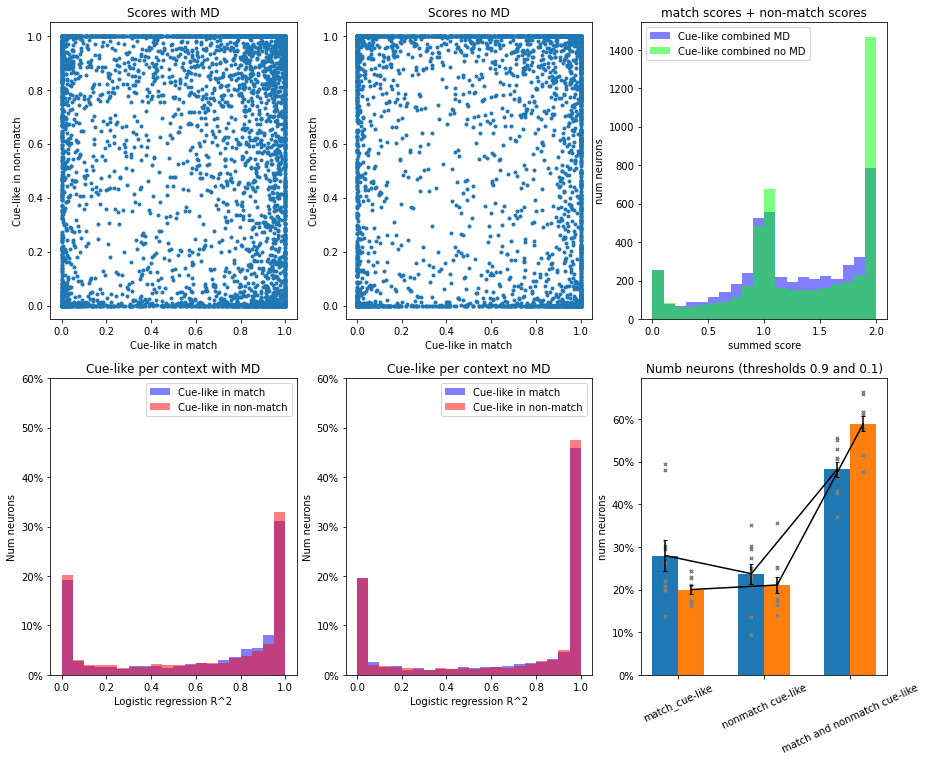

In [21]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D, "perc-cue")
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()


Text(0.5, 1.0, 'Num neurons (thresholds 0.9 and 0.1)')

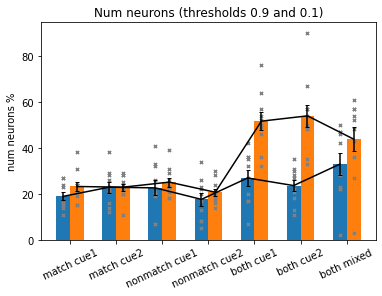

In [22]:
N_PFC_NEURONS = 500
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
                        
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D, "number")
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     

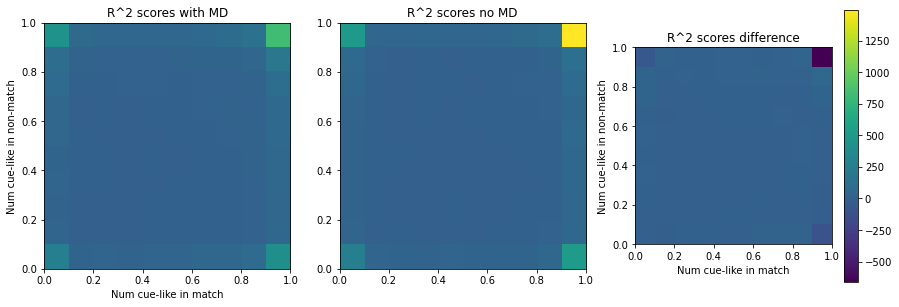

In [23]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

In [ ]:
N_PFC_NEURONS = 500

def get_idxs7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]
        
        match_cue1_neurons.extend([match_neurons[np.where(b[match_neurons,0] == 1)[0]]])
        match_cue2_neurons.extend([match_neurons[np.where(b[match_neurons,0] == -1)[0]]])
        nomatch_cue1_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]])
        nonmatch_cue2_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]])
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.extend([cuelike_cue1_neurons_])
        cuelike_cue2_neurons.extend([cuelike_cue2_neurons_])     
        cuelike_mixed_neurons.extend([np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))])
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) 

(match_cue1_neurons, match_cue2_neurons, nonmatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) = get_idxs7(scores, b)
(match_cue1_neurons_noMD, match_cue2_neurons_noMD, nonmatch_cue1_neurons_noMD, nonmatch_cue2_neurons_noMD, cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD, cuelike_mixed_neurons_noMD) = get_idxs7(scores_noMD, b_noMD)


(3000, 2)
(4000, 72)


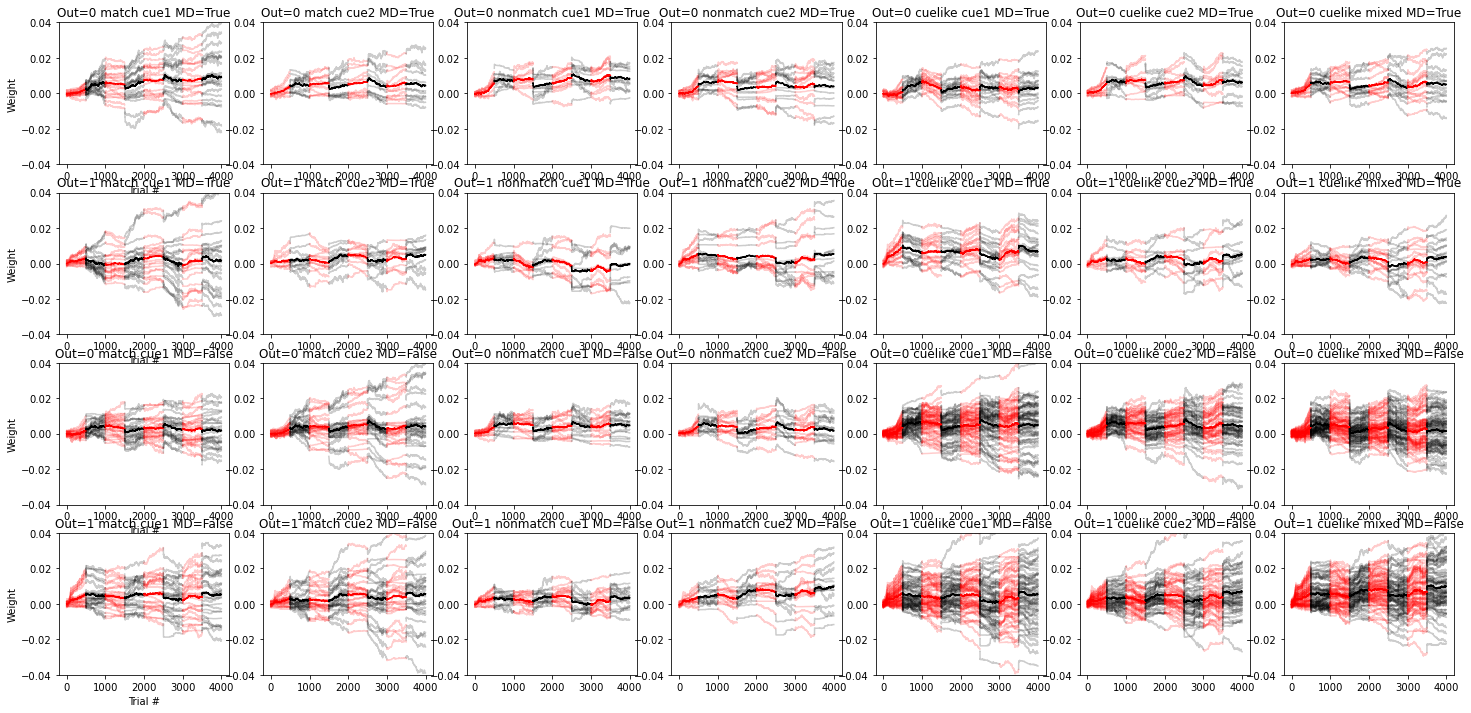

In [13]:
# IGNORE THIS CELL -- I FORGET WHAT'S GOING ON HERE

def plot_weights(run_idx, scores, wPFC_output, scores_noMD, wPFC_output_noMD):
    cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
    cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
    cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
    cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
    cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
    cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

    x = np.arange(0,4000)
    wPFC_out0_all = wPFC_output[match_trials,0,:]
    wPFC_out1_all = wPFC_output[match_trials,1,:]
    wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
    wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

    m0 = np.mean(wPFC_out0_all,1)
    m1 = np.mean(wPFC_out1_all,1)
    e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
    e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

    m0_noMD = np.mean(wPFC_out0_all_noMD,1)
    m1_noMD = np.mean(wPFC_out1_all_noMD,1)
    e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
    e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

    wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons[run_idx]]
    wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons[run_idx]]
    wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]]
    wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons[run_idx]]
    wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons[run_idx]]

    wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons[run_idx]]
    wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons[run_idx]]
    wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]]
    wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons[run_idx]]
    wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons[run_idx]]

    wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]]
    wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]]

    wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]]
    wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]]

    def plt_trials(ax, w):
        if w.shape[1] == 0:
            return

        match_blocks = [1,3,5,7]
        nmatch_blocks = [0,2,4,6]

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            m = np.mean(w[s:t,:],1)
            e = np.std(w[s:t,:],1)        
            ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#             ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    plt_trials(ax1,wPFC_out0_match_cue1_MD)
    ax1.set_ylim((-0.04,0.04))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    plt_trials(ax2,wPFC_out0_match_cue2_MD)
    ax2.set_ylim((-0.04,0.04))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
    ax3.set_ylim((-0.04,0.04))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
    ax4.set_ylim((-0.04,0.04))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
    ax5.set_ylim((-0.04,0.04))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
    ax6.set_ylim((-0.04,0.04))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
    ax7.set_ylim((-0.04,0.04))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    plt_trials(ax8,wPFC_out1_match_cue1_MD)
    ax8.set_ylim((-0.04,0.04))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    plt_trials(ax9,wPFC_out1_match_cue2_MD)
    ax9.set_ylim((-0.04,0.04))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
    ax10.set_ylim((-0.04,0.04))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
    ax11.set_ylim((-0.04,0.04))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
    ax12.set_ylim((-0.04,0.04))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
    ax13.set_ylim((-0.04,0.04))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
    ax14.set_ylim((-0.04,0.04))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    plt_trials(ax15,wPFC_out0_match_cue1_noMD)
    ax15.set_ylim((-0.04,0.04))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    plt_trials(ax16,wPFC_out0_match_cue2_noMD)
    ax16.set_ylim((-0.04,0.04))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
    ax17.set_ylim((-0.04,0.04))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
    ax18.set_ylim((-0.04,0.04))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
    ax19.set_ylim((-0.04,0.04))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
    ax20.set_ylim((-0.04,0.04))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
    ax21.set_ylim((-0.04,0.04))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    plt_trials(ax22,wPFC_out1_match_cue1_noMD)
    ax22.set_ylim((-0.04,0.04))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    plt_trials(ax23,wPFC_out1_match_cue2_noMD)
    ax23.set_ylim((-0.04,0.04))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
    ax24.set_ylim((-0.04,0.04))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
    ax25.set_ylim((-0.04,0.04))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
    ax26.set_ylim((-0.04,0.04))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
    ax27.set_ylim((-0.04,0.04))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
    ax28.set_ylim((-0.04,0.04))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    print(wPFC_out1_cuelike_mixed_noMD.shape)

    plt.show()

    
(_, _, _, wPFC_output) = load_obj(RUNS_MD[5])
(_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[5])
plot_weights(5, scores[2500:3000], wPFC_output, scores_noMD[2500:3000], wPFC_output_noMD)

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


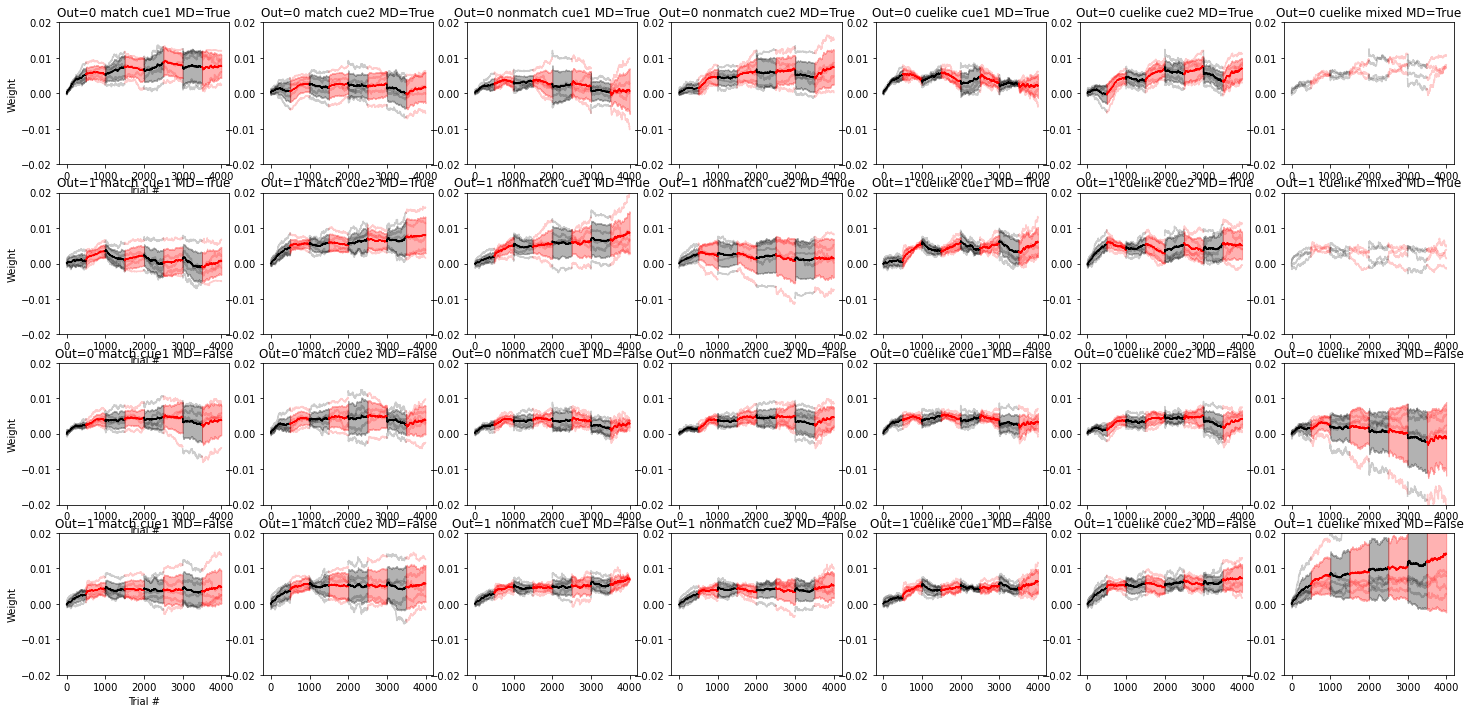

In [27]:
def plt_trials(ax, w, starts_with_match=True):
    if w.shape[1] == 0:
        return

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)
        c = 'k' if c == 'r' else 'r'

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
        ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)
        c = 'k' if c == 'r' else 'r'

def plot_weights(scores_, scores_noMD_):
    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    ax1.set_ylim((-0.02,0.02))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    ax2.set_ylim((-0.02,0.02))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    ax3.set_ylim((-0.02,0.02))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    ax4.set_ylim((-0.02,0.02))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    ax5.set_ylim((-0.02,0.02))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    ax6.set_ylim((-0.02,0.02))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    ax7.set_ylim((-0.02,0.02))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    ax8.set_ylim((-0.02,0.02))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    ax9.set_ylim((-0.02,0.02))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    ax10.set_ylim((-0.02,0.02))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    ax11.set_ylim((-0.02,0.02))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    ax12.set_ylim((-0.02,0.02))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    ax13.set_ylim((-0.02,0.02))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    ax14.set_ylim((-0.02,0.02))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    ax15.set_ylim((-0.02,0.02))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    ax16.set_ylim((-0.02,0.02))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    ax17.set_ylim((-0.02,0.02))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    ax18.set_ylim((-0.02,0.02))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    ax19.set_ylim((-0.02,0.02))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    ax20.set_ylim((-0.02,0.02))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    ax21.set_ylim((-0.02,0.02))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    ax22.set_ylim((-0.02,0.02))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    ax23.set_ylim((-0.02,0.02))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    ax24.set_ylim((-0.02,0.02))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    ax25.set_ylim((-0.02,0.02))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    ax26.set_ylim((-0.02,0.02))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    ax27.set_ylim((-0.02,0.02))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    ax28.set_ylim((-0.02,0.02))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    N_TRIALS = 4000
    N_SIMS = 5
    wPFC_out0_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out0_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))
    
    for run_idx in range(0,5):
        i = run_idx #run_idx - 5
        s = run_idx * 500
        t = run_idx * 500 + 500
        scores = scores_[s:t]
        scores_noMD = scores_noMD_[s:t]
        (_, _, _, wPFC_output) = load_obj(RUNS_MD[run_idx])
        (_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[run_idx])
    
        cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
        cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
        cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
        cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
        cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
        cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

        x = np.arange(0,4000)
        wPFC_out0_all = wPFC_output[match_trials,0,:]
        wPFC_out1_all = wPFC_output[match_trials,1,:]
        wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
        wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

        m0 = np.mean(wPFC_out0_all,1)
        m1 = np.mean(wPFC_out1_all,1)
        e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
        e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

        m0_noMD = np.mean(wPFC_out0_all_noMD,1)
        m1_noMD = np.mean(wPFC_out1_all_noMD,1)
        e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
        e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

        wPFC_out0_match_cue1_MD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons[run_idx]],1)
        wPFC_out0_match_cue2_MD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out1_match_cue1_MD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons[run_idx]],1)
        wPFC_out1_match_cue2_MD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out0_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]],1)

        wPFC_out1_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]],1)


    plt_trials(ax1,wPFC_out0_match_cue1_MD)

    plt_trials(ax2,wPFC_out0_match_cue2_MD)

    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)

    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)

    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)

    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)

    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)

    plt_trials(ax8,wPFC_out1_match_cue1_MD)

    plt_trials(ax9,wPFC_out1_match_cue2_MD)

    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)

    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)

    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)

    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)

    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)

    plt_trials(ax15,wPFC_out0_match_cue1_noMD)

    plt_trials(ax16,wPFC_out0_match_cue2_noMD)

    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)

    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)

    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)

    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)

    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)

    plt_trials(ax22,wPFC_out1_match_cue1_noMD)

    plt_trials(ax23,wPFC_out1_match_cue2_noMD)

    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)

    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)

    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)

    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)

    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)

    plt.show()    

plot_weights(scores, scores_noMD)

# See neurons inputs/encoding breadown


[array([ 27,  29,  33,  62,  65,  67,  73,  74,  86,  87,  92, 100, 110,
       114, 116, 124, 127, 134, 135, 141, 145, 148, 149, 153, 154, 156,
       166, 171, 180, 209, 373, 425]), array([ 13,  29,  31,  40,  43,  47,  48,  54,  57,  59,  67,  69,  71,
        73,  81,  86,  90, 102, 114, 121, 136, 146, 152, 153, 156, 157,
       166, 168, 171, 180, 184, 185, 187, 196, 199, 250, 379, 387, 401,
       410, 414, 472, 485, 497]), array([ 22,  27,  54,  64,  70,  74,  78,  80,  98, 102, 124, 133, 134,
       136, 148, 161, 163, 184, 187, 193, 203, 209, 250, 340, 352, 373,
       387, 427, 489]), array([  1,   3,  13,  22,  23,  33,  35,  40,  48,  54,  60,  78,  80,
        86,  96, 100, 112, 114, 134, 135, 149, 153, 154, 156, 161, 163,
       168, 190, 193, 194, 209, 223, 227, 340, 342, 467, 494]), array([ 11,  33,  73,  74, 129, 141, 153, 154, 174, 179, 185, 342, 352,
       379]), array([  3,  11,  12,  22,  27,  29,  45,  64,  66,  71,  73,  74,  96,
        99, 110, 133, 135, 136, 

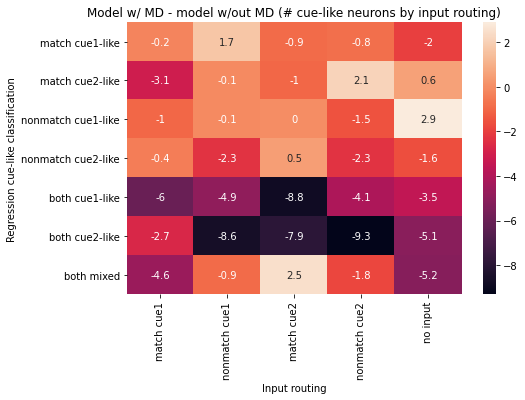

In [52]:
def count_groups(X):
    Y = []
    for arr in X:
        d = [0, 0, 0, 0, 0]
        for neuron_idx in arr:
            if neuron_idx < 100:
                d[0] = d[0] + 1
            elif neuron_idx < 200:
                d[1] = d[1] + 1
            elif neuron_idx < 300:
                d[2] = d[2] + 1
            elif neuron_idx < 400:
                d[3] = d[3] + 1
            elif neuron_idx < 500:
                d[4] = d[4] + 1
        Y.append(d)
    return Y

def comp_diff(a,b):
    A = np.matrix(count_groups(a))
    B = np.matrix(count_groups(b))
    return np.subtract(A,B).tolist()
    
D = {}
D["match cue1"] = comp_diff(match_cue1_neurons, match_cue1_neurons_noMD)
D["match cue2"] = comp_diff(match_cue2_neurons, match_cue2_neurons_noMD)
D["nonmatch cue1"] = comp_diff(nonmatch_cue1_neurons, nonmatch_cue1_neurons_noMD)
D["nonmatch cue2"] = comp_diff(nonmatch_cue2_neurons, nonmatch_cue2_neurons_noMD)
D["both cue1"] = comp_diff(cuelike_cue1_neurons, cuelike_cue1_neurons_noMD)
D["both cue2"] = comp_diff(cuelike_cue2_neurons, cuelike_cue2_neurons_noMD)
D["both mixed"] = comp_diff(cuelike_mixed_neurons, cuelike_mixed_neurons_noMD)

Ms = []
for i in range(len(D["match cue1"])):
    M = [D["match cue1"][i], 
         D["match cue2"][i],
         D["nonmatch cue1"][i],
         D["nonmatch cue2"][i],
         D["both cue1"][i],
         D["both cue2"][i],
         D["both mixed"][i]]
    Ms.append(M)

F = np.zeros((len(Ms[0]), len(Ms[0][0])))
    
for r in range(len(Ms[0])):
    for c in range(len(Ms[0][0])):
        s = 0
        for idx in range(len(D["match cue1"])):
            s = s + Ms[idx][r][c]
        F[r,c] = s / len(D["match cue1"])
        
        
cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'nonmatch cue1', 'match cue2', 'nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("Model w/ MD - model w/out MD (# cue-like neurons by input routing)")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

<ipython-input-25-f1dfce12a37f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(match_cue1_neurons).shape)


(10,)
[[ 5 10  7  3  6]
 [ 3  2  7  8  4]
 [ 1  2  0  0  3]
 [ 1  1  0  0  1]
 [ 3  1  2  4  0]
 [ 3  0  6  8  2]
 [ 6  5  9  3  3]]
[5, 3, 1, 1, 3, 3, 6]
[10, 2, 2, 1, 1, 0, 5]


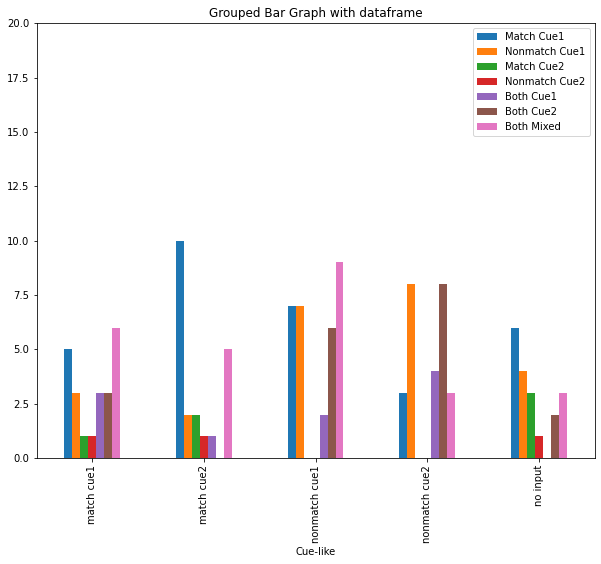

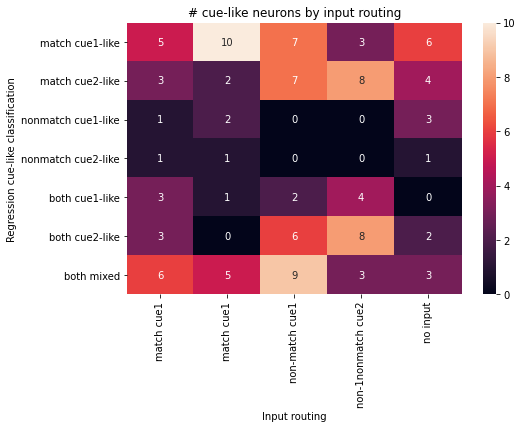

In [25]:
import pandas as pd
from operator import add

print(np.array(match_cue1_neurons).shape)

def get_plot_group(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 8
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_group_noMD(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group(neuron_idx)
        D = list(map(add, D, group))
    return D

def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group_noMD(neuron_idx)
        D = list(map(add, D, group))
    return D
  
    
D_0_100 = ["match cue1"] + get_plot_data(0,100)
D_100_200 = ["match cue2"] + get_plot_data(100,200)
D_200_300 = ["nonmatch cue1"] + get_plot_data(200,300)
D_300_400 = ["nonmatch cue2"] + get_plot_data(300,400)
D_400_500 = ["no input"] + get_plot_data(400,500)

# D_0_100 = ["match cue1"] + get_plot_data_noMD(0,100)
# D_100_200 = ["match cue2"] + get_plot_data_noMD(100,200)
# D_200_300 = ["nonmatch cue1"] + get_plot_data_noMD(200,300)
# D_300_400 = ["nonmatch cue2"] + get_plot_data_noMD(300,400)
# D_400_500 = ["no input"] + get_plot_data_noMD(400,500)

df = pd.DataFrame([D_0_100, D_100_200, D_200_300, D_300_400, D_400_500],
                  columns=['Cue-like', 'Match Cue1', 'Nonmatch Cue1', 'Match Cue2', 'Nonmatch Cue2', 'Both Cue1', 'Both Cue2', 'Both Mixed'])
df.plot(figsize=(10,8),
        x='Cue-like',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',
        ylim=(0,20))

D_match_cue1 = get_plot_data(0,100)
D_match_cue2 = get_plot_data(100,200)
D_nonmatch_cue1 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_match_cue2, D_nonmatch_cue1, D_nonmatch_cue2, D_noinput]))

print(F)
print(D_match_cue1)
print(D_match_cue2)

cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'match cue1', 'non-match cue1', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

In [27]:
# Produce difference matrix plot (take mean over each initalization)

1

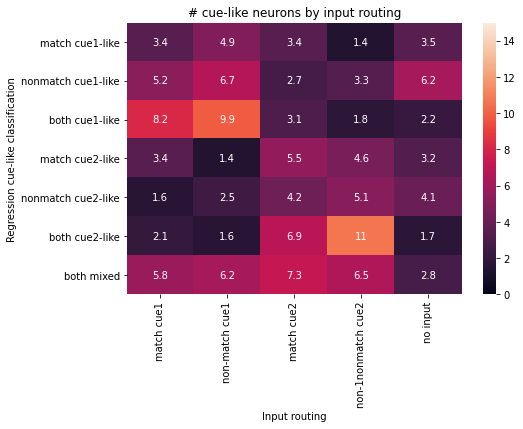

In [17]:
## THESE ARE THE GOOD 2D HIST PLOTS!


import pandas as pd
from operator import add

def get_plot_group(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[2] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data(0,100)
D_nonmatch_cue1 = get_plot_data(100,200)
D_match_cue2 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'nonmatch cue1-like', 'both cue1-like', 'match cue2-like', 'nonmatch cue2-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()


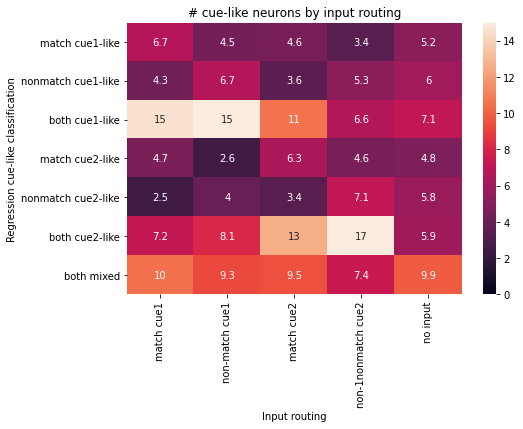

In [18]:
import pandas as pd
from operator import add

def get_plot_group_noMD(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group_noMD(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data_noMD(0,100)
D_nonmatch_cue1 = get_plot_data_noMD(100,200)
D_match_cue2 = get_plot_data_noMD(200,300)
D_nonmatch_cue2 = get_plot_data_noMD(300,400)
D_noinput = get_plot_data_noMD(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'nonmatch cue1-like', 'both cue1-like', 'match cue2-like', 'nonmatch cue2-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

